# I. Introduction

# II. Imports

## A Standard imports

In [1]:
# Standard imports
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import re
import seaborn as sns
import statistics as stat
import time

## B Related third party imports

In [2]:
from collections import Counter
from collections import defaultdict

from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

## C Local application / library specific imports.

In [3]:
pip install --upgrade kmodes

In [4]:
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

# Import module for data visualization
from plotnine import *
import plotnine

# scipy
#from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

# scikitlearn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# warnings
import warnings

# III. Data presentation

## A Chargement

In [5]:
CHEMIN = 'drive/My Drive/Colab Notebooks/ocr_data_scientist/P5 Segmentation client/data/'
CUSTOMERS = 'olist_customers_dataset.csv'
GEOLOCATION = 'olist_geolocation_dataset.csv'
ORDER_ITEMS = 'olist_order_items_dataset.csv'
ORDER_PAYMENTS = 'olist_order_payments_dataset.csv'
ORDER_REVIEWS = 'olist_order_reviews_dataset.csv'
ORDERS = 'olist_orders_dataset.csv'
PRODUCTS = 'olist_products_dataset.csv'
SELLERS = 'olist_sellers_dataset.csv'

In [6]:
customers_df = pd.read_csv(
    CHEMIN + CUSTOMERS,
    sep=','
    )
customers_df.name = 'Customers'

geolocation_df = pd.read_csv(
    CHEMIN + GEOLOCATION,
    sep=','
    )
geolocation_df.name = 'Geolocation'

order_items_df = pd.read_csv(
    CHEMIN + ORDER_ITEMS,
    sep=','
    )
order_items_df.name = 'Order items'

order_payments_df = pd.read_csv(
    CHEMIN + ORDER_PAYMENTS,
    sep=','
    )
order_payments_df.name = 'Order payments'

order_reviews_df = pd.read_csv(
    CHEMIN + ORDER_REVIEWS,
    sep=','
    )
order_reviews_df.name = 'Order reviews'

orders_df = pd.read_csv(
    CHEMIN + ORDERS,
    sep=','
    )
orders_df.name = 'Orders'

products_df = pd.read_csv(
    CHEMIN + PRODUCTS,
    sep=','
    )
products_df.name = 'Products'

sellers_df = pd.read_csv(
    CHEMIN + SELLERS,
    sep=','
    )
sellers_df.name = 'Sellers'

In [7]:
my_dataframelist = [customers_df,
                    geolocation_df,
                    order_items_df,
                    order_payments_df,
                    order_reviews_df,
                    orders_df,
                    products_df,
                    sellers_df]

In [8]:
# Ignore warnings
warnings.filterwarnings(
    'ignore',
    category = FutureWarning
    )

## B Description

In [9]:
for dataframe in my_dataframelist:
    print('\n------------------')
    for column in dataframe.columns:
        print(column)


------------------
customer_id
customer_unique_id
customer_zip_code_prefix
customer_city
customer_state

------------------
geolocation_zip_code_prefix
geolocation_lat
geolocation_lng
geolocation_city
geolocation_state

------------------
order_id
order_item_id
product_id
seller_id
shipping_limit_date
price
freight_value

------------------
order_id
payment_sequential
payment_type
payment_installments
payment_value

------------------
review_id
order_id
review_score
review_comment_title
review_comment_message
review_creation_date
review_answer_timestamp

------------------
order_id
customer_id
order_status
order_purchase_timestamp
order_approved_at
order_delivered_carrier_date
order_delivered_customer_date
order_estimated_delivery_date

------------------
product_id
product_category_name
product_name_lenght
product_description_lenght
product_photos_qty
product_weight_g
product_length_cm
product_height_cm
product_width_cm

------------------
seller_id
seller_zip_code_prefix
seller_city

Pour la plupart des dataframes, les noms de colonne commencent par le nom du dataframe en question. Il y a deux exceptions : les clés étrangères, et, pour une raison inconnue, le dataframe order_item.

Par souci de normalisation, nous allons modifier les noms des colonnes suivantes, dans le dataframe order_item :

*   shipping_limit_date
*   price
*   freight_value

In [10]:
order_items_df.rename(
    columns={'shipping_limit_date':'item_shipping_limit_date',
             'price':'item_price',
             'freight_value':'item_freight_value'
             },
             inplace=True
             )
print(
    order_items_df.columns
    )

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'item_shipping_limit_date', 'item_price', 'item_freight_value'],
      dtype='object')


In [11]:
temp_int = customers_df['customer_id'].nunique() - customers_df['customer_unique_id'].nunique()
temp_frac = round(
    temp_int / customers_df['customer_id'].nunique()*100,
    3
    )
print(
    'Proportion de clients ayant passé plusieurs commandes : {}%.'.format(
        temp_frac
        )
)

Proportion de clients ayant passé plusieurs commandes : 3.364%.


# IV. Analyse exploratoire

In [12]:
temp_df = order_items_df
non_relevant_columns = ['seller_id','product_id',
                        'order_id','item_shipping_limit_date']
date_columns = []
hour_columns = []
col_to_log = ['item_freight_value','item_price']
col_to_multiply = []

## A Fonctions

Nous allons explorer les données qualitatives, puis les données quantitatives.

Nous voulons :
- estimer la pertinence de chaque catégorie de donnée,
- comprendre le contenu de chaque catégorie,
- ne retenir que les catégories vraiment utiles à notre analyse, c'est-à-dire uniquement les grandeurs dont nous pensons qu'elles peuvent avoir une influence sur les valeurs cibles (les *targets*).

### 1 Fonctions générales

In [13]:
def nan_proportion(
    my_dataframe
    ):
    ''' Returns the proportion of NaN values in the whole dataframe.'''

    # Check argument type
    if not isinstance(my_dataframe, pd.DataFrame):
        return print('L\'argument donné n\'est pas de type pd.DataFrame')

    # Compute the value of Nan proportion
    nan_proportion = my_dataframe.isna().sum().sum() / _
    (my_dataframe.shape[0]*my_dataframe.shape[1]) * 100

    return nan_proportion

In [14]:
def get_pareto(
    my_dataframe,
    my_column,
    my_filter=10,
    y_inf=0,
    y_sup=3500
    ):
    '''Function that takes a list and returns a bar graph of the most common
    elements of the list.'''

    # Check that the colomn name really is in the dataframe
    if my_column not in my_dataframe.columns:
        return 'La colonne n\'est pas dans le DataFrame'

    # Check that the column dtype is object
    if my_dataframe[my_column].dtype != object:
        plt.figure(
            figsize=(
                math.sqrt(my_filter*2),
                math.sqrt(my_filter*2)
                )
            )
        ax = plt.axes()
        ax.yaxis.grid()  # horizontal lines
        plt.ylim(
            (y_inf,
             y_sup)
            )
        plt.title('Colonne {} - Histogramme'.format(my_column))
        plt.hist(my_dataframe[my_column],
                 bins=100,
                 color='blue',
                 edgecolor='black'
                 )
        return 'Les éléments de la colonne {} '
        'ne sont pas de type \'object\''.format(my_column)

    # Extract list of categories and  their occurrence frequency
    temp_counter = Counter(
        my_dataframe[my_column]
        ).most_common(
            my_filter
            )
    categories, frequencies = zip(
        *temp_counter
        )
    max_ = len(
        my_dataframe[my_column]
        )
    frequencies = [value/max_*100 for value in frequencies]

    # Delete the NaN category
    temp_df = pd.DataFrame(
        {'Categories':categories,
         'Frequencies':frequencies}
         )
    temp_df = temp_df.dropna()
    categories = [element for element in temp_df['Categories']]
    frequencies= [element for element in temp_df['Frequencies']]

    # Plot the graph
    plt.figure(
        figsize=(
            math.sqrt(my_filter*2),
            math.sqrt(my_filter*2)
            )
        )
    plt.title('Fréquence d\'apparition des {}. {} '
              'premiers éléments'.format(my_column, my_filter))
    if max(frequencies) > 5:
        plt.xlim((0, 110))
    else:
        plt.xlim((0, max(frequencies)*1.1))
    plt.xlabel('Occurrences en % de la taille de l\'échantillon')
    plt.ylabel('Catégories')
    ax = plt.axes()
    # vertical lines
    ax.xaxis.grid()
    try:
        plt.barh(
            categories,
            frequencies,
            color='orange',
            edgecolor='k'
            )
    except TypeError:
        return categories, frequencies

In [15]:
def quant_qual(
    my_dataframe
    ):
    ''' Analyser séparément des variables quantitives et des variables
    qualitatives.'''

    # Check if the argument given really is a dataframe
    if not isinstance(my_dataframe, pd.DataFrame):
        return print('L\'argument donné n\'est pas de type pd.DataFrame')

    # Create the quantitative dataframe
    quantitative_columns = [column for column in my_dataframe.columns 
                            if my_dataframe[column].dtype != object]
    quantitative_df = my_dataframe[quantitative_columns]

    # Create the qualitative dataframe
    qualitative_columns = [column for column in my_dataframe.columns 
                           if my_dataframe[column].dtype == object]
    qualitative_df = my_dataframe[qualitative_columns]

    return (quantitative_df, qualitative_df)

In [16]:
def get_non_nan(
    my_dataframe,
    my_df_name=''
    ):
    '''  Représenter les données non-NaN pour chaque colonne.'''
    
    # Check that the colomn name really is in the dataframe
    if not isinstance(my_dataframe, pd.DataFrame):
        return 'DataFrame type expected.'

    temp_dict = {}

    # Compute the proportion of non-Nan values.
    for column in my_dataframe.columns:
        temp_dict[column] = my_dataframe[column].notna().sum()

    # Sort the items of the created dictionnary by values
    tuples_list = sorted(
        temp_dict.items(),
        key=lambda item: item[1],
        reverse=False
        )
    t_keys = [item[0] for item in tuples_list]
    t_values = [item[1]/my_dataframe.shape[0]*100 for item in tuples_list]

    # Determine the color of the bars according to the type of the data
    try:
        if my_dataframe[column].dtype != object:
            color_ = 'blue'
            title_ = 'Proportion de données non-Nan quantitatives ' + my_df_name
        else:
            color_ = 'orange'
            title_ = 'Proportion de données non-Nan qualitatives ' + my_df_name
    except UnboundLocalError:
        return print('Dataframe vide')
        
    # Plot the graph
    plt.figure(figsize=(
        5,
        math.sqrt(3*len(t_keys))
        )
    )
    plt.xlim((0, 110))
    ax = plt.axes()
    # Display vertical lines
    ax.xaxis.grid()
    plt.title('{} ({})'.format(
        title_,
        len(tuples_list)
        )
    )
    plt.barh(
        t_keys,
        t_values,
        color=color_,
        edgecolor='k'
        )

In [17]:
def decompose_date(
    my_dataframe,
    my_columns,
    my_param='Year'
    ):
    ''' Créer 4 colonnes à partir de la colonne des dates :
        - l'année
        - le mois
        - le jour du mois
        - le jour de la semaine
    La finalité est de visualiser la dispersion de ces données d'une part, 
    et d'autre part de s'en servir pour l'ACP.'''

    if my_columns == []:
        return print('Aucune colonne donnée.')

    for i, col_ in enumerate(my_columns):
        # Créer les nouvelles colonnes
        my_dataframe[col_] = pd.to_datetime(my_dataframe[col_])
        my_dataframe['Year'+'_'+str(i+1)] = my_dataframe[col_].dt.year
        my_dataframe['Month'+'_'+str(i+1)] = my_dataframe[col_].dt.month
        my_dataframe['Month day'+'_'+str(i+1)] = my_dataframe[col_].dt.day
        my_dataframe['Week day'+'_'+str(i+1)] = my_dataframe[col_].dt.weekday
        # Enlever la colonne de dates brutes
        my_df = my_dataframe.drop(
            col_,
            axis=1,
            inplace=False
            )

    return my_df.head(3)

In [18]:
def drop_columns(
    my_dataframe,
    drop_columns=[]
    ):
    ''' Rejeter les colonnes selon le jugement du rédacteur.'''

    my_df = my_dataframe.copy()

    for column in drop_columns:
        my_df.drop(
            column,
            axis=1,
            inplace=True
            )

    return my_df

In [19]:
def extract_date(
    my_dataframe,
    my_column,
    suffix,
    replace
    ):
    ''' Extract the date format'''

    # ----------------------------------------------------
    # Vérifications
    # ----------------------------------------------------

    # Vérifier le type du dataframe
    if not isinstance(
        my_dataframe,
        pd.DataFrame
        ):
        return print(
            'L\'argument donné n\'est pas de type pd.DataFrame'
            )

    # Vérifier la présence de la colonne dans le dataframe
    if my_column not in my_dataframe.columns:
        return print(
            'Given column absent from given dataframe.'
        )

    # Vérifier le type du suffixe
    if not isinstance(suffix, str):
        return print('Suffix not of string type.')

    # ----------------------------------------------------
    # Exécution
    # ----------------------------------------------------

    # Create the new column
    my_dataframe[my_column] = pd.to_datetime(my_dataframe[my_column])
    my_dataframe['Date' + '_' + suffix] = my_dataframe[my_column].dt.date
    my_dataframe.drop(my_column, axis=1, inplace=replace)

    return my_dataframe

In [20]:
def date_extraction(
    my_dataframe,
    my_column,
    my_units,
    suffix,
    replace
    ):
    '''
    Converts the datetime feature into the selected list of units, 
    which can contain :
    - year ..........   2 values
    - quarter .......   4 values
    - weekday .......   7 values
    - month .........  12 values
    - hour ..........  24 values
    - day ...........  31 values
    - calendar_week .  52 values
    - calendar day .. 365 values
    Then encode the selected unit.
    '''

    # ----------------------------------------------------
    # Vérifications
    # ----------------------------------------------------

    # Vérifier le type du dataframe
    if not isinstance(
        my_dataframe,
        pd.DataFrame
        ):
        return print(
            'L\'argument donné n\'est pas de type pd.DataFrame'
            )

    # Vérifier la présence de la colonne dans le dataframe
    if my_column not in my_dataframe.columns:
        return print(
            'Given column absent from given dataframe.'
        )

    # Vérifier la pertinence des unités données
    my_units_ = ['year',
                 'quarter',
                 'weekday',
                 'month',
                 'hour',
                 'day',
                 'calendar_week',
                 'calendar_day']
    if not my_units:
        return print(
            'No unit given. Please enter a unit among the following '
            + 'ones: {}'.format(my_units_)
            )
    if not set(my_units).intersection(my_units_):
        return print(
            'Unknown unit. Please enter a unit among the following '
            + 'ones: {}'.format(my_units_)
            )

    # Vérifier le type du suffixe
    if not isinstance(suffix, str):
        return print('Suffix not of string type.')

    # ----------------------------------------------------
    # Exécution
    # ----------------------------------------------------

    # Conversion des dates en format date
    my_dataframe[my_column] = pd.to_datetime(
        my_dataframe[my_column]
        )

    # Conversion des dates en années (2)
    if 'year' in my_units:
        my_dataframe['y(2)_' + suffix] = my_dataframe[my_column].dt.year
    
    # Conversion des dates en trimestre (4)
    if 'quarter' in my_units:
        my_dataframe['q(4)_' + suffix] = my_dataframe[my_column].dt.quarter
    
    # Conversion des dates en jour de la semaine (7)
    if 'weekday' in my_units:
        my_dataframe['wd(7)_' + suffix] = my_dataframe[my_column].dt.weekday
    
    # Conversion des dates en mois (12)
    if 'month' in my_units:
        my_dataframe['m(12)_' + suffix] = my_dataframe[my_column].dt.month

        # Conversion des dates en heure (24)
    if 'hour' in my_units:
        my_dataframe['h(24)_' + suffix] = my_dataframe[my_column].dt.hour

    # Conversion des dates en jours (31)
    if 'day' in my_units:
        my_dataframe['d(31)_' + suffix] = my_dataframe[my_column].dt.day

    # Conversion des dates en semaines calendaires (52)
    if 'calendar_week' in my_units:
        my_dataframe['cw(52)_' + suffix] = [element.isocalendar()[1]
                                            for element 
                                            in my_dataframe[my_column]]

    # Conversion des dates en jours calendaires (365)
    if 'calendar_day' in my_units:
        my_dataframe['cd(365)_' + suffix] = [element.timetuple()[7]
                                             for element 
                                             in my_dataframe[my_column]]

    return my_dataframe

### 2 OneHotEncoder

In [21]:
def encode_me_that(
    my_dataframe,
    my_code_columns=[],
    my_drop_columns=[],
    my_rate=0.02):
    '''Encoder automatiquement un dataframe en gardant les valeurs présentes
    à plus de n%.'''

    # Supprimer les colonnes non pertinentes
    my_df = my_dataframe.drop(
        my_drop_columns,
        axis=1,
        inplace=False
        )
    
    if my_code_columns ==[]:
        # Sélectionner les colonnes qualitatives uniquement
        my_qual_df = my_df.select_dtypes(
            ['object']
            )
        qual_columns = my_qual_df.columns
    else:
        my_qual_df = my_df[my_code_columns]
        if isinstance(my_code_columns, list):
            qual_columns = my_qual_df.columns
        elif isinstance(my_code_columns, str):
            qual_columns = my_code_columns
        else:
            return print('Wrong type of column given')
    
    my_qual_df = my_qual_df.dropna()

    # Rejeter les valeurs représentant moins de n% de chaque colonne
    total_length = len(my_qual_df)
    repr_values = {}    

    if isinstance(my_code_columns, str):
        repr_values[my_code_columns] = [element for element
                                        in my_qual_df.unique()
                                        if my_qual_df.value_counts()[element] > my_rate * total_length]
        #my_qual_df = my_qual_df.array.reshape(-1, 1)
        my_qual_df = my_qual_df.to_numpy()
    else:
        for my_column in qual_columns:
            repr_values[my_column] = [element for element
                                      in my_qual_df[my_column].unique()
                                      if my_qual_df[my_column].value_counts()[element] > my_rate * total_length]

    # Encoder les données
    enc = OneHotEncoder(
        handle_unknown='ignore',
        categories=list(
            repr_values.values()
            )
        )
    my_dataframetransformed = enc.fit_transform(
        my_qual_df
        ).toarray()

    # Récupérer les noms colonnes
    onehot_qual_columns = enc.get_feature_names(
        input_features=None
        )
    my_qual_df = pd.DataFrame(
        my_dataframetransformed,
        columns=onehot_qual_columns
        )

    # Former le dataframe avec les données encodées
    my_df.drop(
        qual_columns,
        axis=1,
        inplace=True
        )
    my_df = pd.merge(
        my_df.reset_index(),
        my_qual_df,
        left_index=True,
        right_index=True
        )

    # Remplacer les espaces vides par des underscores
    my_df.rename(
        columns = lambda x: x.replace(' ', '_'),
        inplace=True
        )

    # Supprimer la colonne index qui s'est rajoutée
    my_df = drop_columns(
        my_dataframe=my_df,
        drop_columns=['index']
        )

    return my_df

### 3 Transformation logarithmique

In [22]:
def log_transform(my_dataframe,
        cols=[]):
    '''  Transform the given columns through logarithmic function.
    Be careful of the suspicious .dropna() at the end!
    '''

    temp_my_dataframe = my_dataframe
    ##################################
    # Si certaines données sont négatives, transformer toutes les données
    # de manière à ce qu'elles soient toutes positives
    ##################################

    # 
    for column in cols:
        temp_list = []
        for element in temp_my_dataframe[column]:
            if element != 0:
                temp_list.append(math.log(element))
            else:
                temp_list.append(None)
        # Ajouter la transformée logarithmique au dataframe
        temp_my_dataframe['log(' + column + ')'] = temp_list
        temp_my_dataframe.drop(
            column,
            axis=1,
            inplace=True
            ) 

    return temp_my_dataframe.dropna()

### 4 Standard Scaler

In [23]:
def standard_scaler(
    my_dataframe_,
    my_columns_,
    mode_
    ):
    ''' Centralise and standardise the given columns of a given
    dataframe.

    Be careful of the .dropna() at the end !
    '''
    
    # Constituer le dataframe de colonnes quantitatives
    quant_df = my_dataframe_[my_columns_]
    
    # Instancier selon l'argument
    if mode_ == 'std':
        scaler = StandardScaler()
    elif mode_ == 'minmax':
        scaler = MinMaxScaler()
    else:
        return print('Mode non valid.')

    # Appliquer le StandardScaler
    quant_df = scaler.fit_transform(
        quant_df
        )
    # Former un dataframe
    quant_df = pd.DataFrame(
        quant_df,
        columns=my_columns_
        )

    # Constituer le dataframe de colonnes non scalées
    temp_my_dataframe = my_dataframe_.drop(
        my_columns_,
        axis=1,
        inplace=False
        ).reset_index(
            drop=True
        )

    for column in my_columns_:
        temp_my_dataframe[column] = quant_df[column]

    return temp_my_dataframe

### 5 PCA

In [24]:
# Source: cours OCR "Réalisez une analyse exploratoire de données"
def display_circles(
    pcs,
    n_comp,
    pca,
    axis_ranks,
    labels=None,
    label_rotation=0,
    lims=None):
    ''' Display the correlations through arraws in the first factorial plane.'''

    # On affiche les trois premiers plans factoriels, donc les six premières
    # composantes
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # Détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            #elif pcs.shape[1] < 30 :
            else:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            #else :
            #    xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Affichage des flèches
            # S'il y a plus de 30 flèches, on n'affiche pas le triangle à leur
            # extrémité
            if pcs.shape[1] < 30:
                plt.quiver(
                    np.zeros(pcs.shape[1]),
                    np.zeros(pcs.shape[1]),
                    pcs[d1,:],
                    pcs[d2,:],
                    angles='xy',
                    scale_units='xy',
                    scale=1,
                    color="grey"
                    )
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(
                    LineCollection(
                        lines,
                        axes=ax,
                        alpha=.1,
                        color='black')
                )
            
            # Affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(
                            x,
                            y,
                            labels[i],
                            fontsize='14',
                            ha='center',
                            va='center',
                            rotation=label_rotation,
                            color="blue",
                            alpha=0.5
                            )
            
            # Affichage du cercle
            circle = plt.Circle(
                (0,0),
                1,
                facecolor='none',
                edgecolor='b'
                )
            plt.gca().add_artist(circle)

            # Définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Affichage des lignes horizontales et verticales
            plt.plot(
                [-1, 1],
                [0, 0],
                color='grey',
                ls='--'
                )
            plt.plot(
                [0, 0],
                [-1, 1],
                color='grey',
                ls='--'
                )

            # Nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1,
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1,
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1,
                                                                    d2+1))
            plt.show(block=False)

In [25]:
def display_factorial_planes(
    X_projected,
    n_comp,
    pca,
    axis_ranks,
    labels=None,
    alpha=1,
    illustrative_var=None
    ):
    ''' Displays the factorial planes of a given dataframe.'''

    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialisation de la figure       
            fig = plt.figure(
                figsize=(
                    7,
                    6
                    )
                )
        
            # Affichage des points
            if illustrative_var is None:
                plt.scatter(
                    X_projected[:, d1],
                    X_projected[:, d2],
                    alpha=alpha
                    )
            else:
                illustrative_var = np.array(
                    illustrative_var
                    )
                for value in np.unique(illustrative_var):
                    selected = np.where(
                        illustrative_var == value
                        )
                    plt.scatter(
                        X_projected[selected, d1],
                        X_projected[selected, d2],
                        alpha=alpha,
                        label=value
                        )
                plt.legend()

            # Affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(
                        x,
                        y,
                        labels[i],
                        fontsize='14',
                        ha='center',
                        va='center'
                        ) 
                
            # Détermination des limites du graphique
            boundary = np.max(
                np.abs(
                    X_projected[:, [d1, d2]]
                    )
                ) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Affichage des lignes horizontales et verticales
            plt.plot(
                [-100, 100],
                [0, 0],
                color='grey',
                ls='--'
                )
            plt.plot(
                [0, 0],
                [-100, 100],
                color='grey',
                ls='--'
                )

            # Nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel(
                'F{} ({}%)'.format(
                    d1+1,
                    round(
                        100*pca.explained_variance_ratio_[d1],
                        1
                        )
                    )
                )
            plt.ylabel(
                'F{} ({}%)'.format(
                    d2+1,
                    round(
                        100*pca.explained_variance_ratio_[d2],
                        1
                        )
                    )
                )

            plt.title(
                "Projection des individus (sur F{} et F{})".format(
                    d1+1,
                    d2+1
                    )
                )
            plt.show(
                block=False
                )

In [26]:
def display_scree_plot(
    data,
    n_comp
    ):
    ''' Displays the pareto diagram of the proper values of a given dataframe.'''

    pca = decomposition.PCA(
        n_components=n_comp
        )
    pca.fit(
        data
        )
    scree_ = pca.explained_variance_ratio_*100

    # Plot the graph
    fig = plt.figure(
    figsize=(
        6,
        8
        )
    )
    plt.ylim(
        (0, 110)
        )
    plt.bar(
        np.arange(len(scree_))+1,
        scree_
        )
    plt.plot(
        np.arange(len(scree_))+1,
        scree_.cumsum(),
        c="red",
        marker='o'
        )
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(
        block=False
        )

In [27]:
def scree(
    my_data_,
    n_comp
    ):
    ''' Returns the proper values of a given dataframe.'''

    pca = decomposition.PCA(
        n_components=n_comp
        )
    pca.fit(
        my_data_
        )

    return pca.singular_values_

In [28]:
def draw_pca_n_dimensions(
    my_dataframe,
    my_n_components,
    ):
    ''' Transforme l'ensemble de données et affiche les points de données
    selon les deux composantes principales.'''

    # Enlever les valeurs NaN
    my_dataframe = my_dataframe.dropna()
    
    pca = PCA(
        n_components=my_n_components
        )
    my_dataframe_pca = pca.fit_transform(
        my_dataframe
        )

    # Détermination des limites du graphique
    max_x = np.abs(
        max(
            my_dataframe_pca[:, 0]
            )
        )
    max_y = np.abs(
        max(
            my_dataframe_pca[:, 1]
            )
        )
    boundary = max(
        max_x,
        max_y
        )*1.1

    sns.set_theme(
        style="darkgrid"
        )
    a_plot = sns.relplot(
        my_dataframe_pca[:, 0],
        my_dataframe_pca[:, 1],
        )  
    #a_plot = sns.jointplot(my_dataframe_pca[:, 0:1],
    #                       x='Component 1',
    #                       y='Component 2',
    #                       kind="kde"
    #                       )
    a_plot.set(
        xlim=(-boundary,boundary)
        )
    a_plot.set(
        ylim=(-boundary,boundary)
        )
    
    return a_plot

In [29]:
def draw_pca_circle(X_scaled=temp_df,
        n_comp=len(temp_df.columns)):
    ''' Affiche les deux cercles de corrélation : individus et features.'''
    pca = decomposition.PCA(
        n_components=n_comp
        )
    pca.fit(
        X_scaled
        )

    features = X_scaled.columns

    # Cercle des corrélations
    pcs = pca.components_
    display_circles(
        pcs,
        n_comp,
        pca,
        [(0, 1)],
        labels = np.array(features)
        )

    plt.show()

### 6 Fonctions propres au dataframe orders

In [30]:
def create_notice(my_dataframe,
        my_column1,
        my_column2,
        my_new_name):
    ''' Créer une colonne des différences en jours entre deux dates.'''

    # Vérifier le type de my_new_name
    if not isinstance(new_names_, str):
        return print('le nom de la nouvelle colonne n\'est pas de type str.')

    # Garantir que le type de la colonne est bien timestamp
    my_dataframe[my_column1] = pd.to_datetime(my_dataframe[my_column1])
    my_dataframe[my_column2] = pd.to_datetime(my_dataframe[my_column2])

    # Créer la nouvelle colonne
    my_dataframe[my_new_name] = my_dataframe[my_column2] - my_dataframe[my_column1]
    # Convertir les données en secondes
    my_dataframe[my_new_name] = [element.total_seconds() for element in my_dataframe[my_new_name]]

    return my_dataframe.head(3)

### 7 Fonctions propres au dataframe products

In [31]:
def multiply_columns(my_dataframe,
        my_columns,
        my_new_name):
    ''' Creates a new column in the given dataframe by multiplying the given
    columns.'''

    # Vérifier que new_name est de type string
    if not isinstance(my_new_name, str):
        return print('le nom de la nouvelle colonne n\'est pas de type str.')

    columns_number = len(my_columns)

    my_dataframe[my_new_name] = my_dataframe[my_columns[0]]

    for i in range(2, columns_number):
        my_dataframe[my_new_name] = my_dataframe[my_new_name]*my_dataframe[my_columns[i]]
    
    return my_dataframe

### 8 Fonctions propres au dataframe reviews

In [32]:
def most_common_words(
    my_dataframe=order_reviews_df,
    my_columns=['review_comment_title', 'review_comment_message'],
    my_rate=0.05
    ):
    ''' Retourner les mots les plus fréquents dans les commentaires.'''

    # Sélection de la colonne à étudier
    n_col = 1 # 0 ou 1

    # Récupère les données utiles
    temp_my_dataframe = order_reviews_df[my_columns]

    word_list_ = []
    # Constituer la liste des mots les plus courants
    for string_ in temp_my_dataframe[my_columns[n_col]]:
        if isinstance(string_, str):
            for word in string_.split():
                if len(word) > 2:
                    word_list_.append(
                        word.lower()
                        )

    temp_counter_ = Counter(
        word_list_
        ).most_common()

    # Sélection des mots présents dans plus de n% des éléments non vides
    notna_length = len(
        my_dataframe[my_columns[n_col]].dropna()
        )
    temp_counter_ = [element for element in temp_counter_
                     if element[1] > my_rate * notna_length]

    return temp_counter_

<BarContainer object of 23 artists>

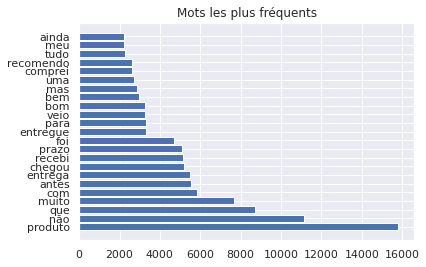

In [33]:
x = [element[0] for element in most_common_words()]
y = [element[1] for element in most_common_words()]
sns.set_theme()
plt.title('Mots les plus fréquents')
plt.barh(x, y)

In [34]:
def encode_reviews(
    my_dataframe=order_reviews_df,
    my_column1='review_comment_message',
    my_column2='review_comment_title'
    ):

    ''' Ajoute et remplit des colonnes au dataframe, dont les noms sont les
    mots les plus fréquents dans les commentaires.
    Chaque colonne est remplie de 0 et de 1 :
        1 si le nom de la colonne est présent dans le commentaire,
        0 sinon.'''

    temp_df_ = my_dataframe

    # Pour les deux colonnes, conversion des types en str
    temp_df_[my_column1].astype('str')
    temp_df_[my_column2].astype('str')

    # Liste des mots les plus fréquents, à connotation positive ou négative,
    # qui dénotent une similitude entre les clients
    #
    # Les mots du type 'non', 'que', 'avec', ... ne dénotent pas une similitude
    # particulière entre les clients, et n'ont pas été gardés.
    message_words = ['bem',
                     'bom',
                     'mas',
                     'recomendo']
    title_words = ['bom',
                   'excelente',
                   'ótima',
                   'otimo',
                   'ótimo',
                   'recomendado',
                   'recomendo',
                   'super']

    # Créer les colonnes, en les remplissant de 0
    for word in message_words:
        temp_df_['m_' + word] = [0]*len(temp_df_)
    for word in title_words:
        temp_df_['t_' + word] = [0]*len(temp_df_)

    # Créer les nouvelles colonnes pour le contenu des messages
    for i, element in enumerate(temp_df_[my_column1]):
        # Ne pas traiter les NaN
        if isinstance(element, str):
            # Enumérer les mots du titre
            for word in element.split(' '):
                # Tester si le mot fait partie des mots les plus fréquents
                if word in message_words:
                    temp_df_['m_'+word][i] = 1
    
    # Créer les nouvelles colonnes pour le title des messages
    for i, element in enumerate(temp_df_[my_column2]):
        # Ne pas traiter les NaN
        if isinstance(element, str):
            # Enumérer les mots du titre
            for word in element.split(' '):
                # Tester si le mot fait partie des mots les plus fréquents
                if word in title_words:
                    temp_df_['t_'+word][i] = 1

    temp_df_.drop(
        my_column1,
        axis=1,
        inplace=True
        )
    temp_df_.drop(
        my_column2,
        axis=1,
        inplace=True
        )

    return temp_df_

## B Exécution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



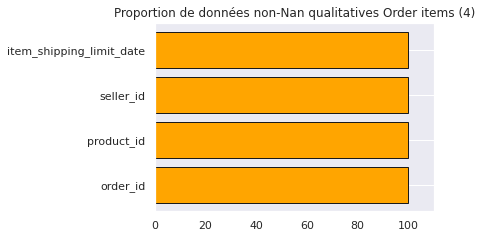

In [35]:
temp_quant_df, temp_qual_df = quant_qual(temp_df)
get_non_nan(
    temp_qual_df,
    temp_df.name
    )

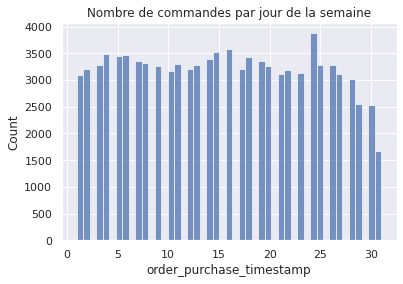

In [36]:
orders_df['order_purchase_timestamp'] = orders_df['order_purchase_timestamp'].astype('datetime64')
x = orders_df['order_purchase_timestamp'].dt.day
plt.title('Nombre de commandes par jour de la semaine')
sns.histplot(x)

### 1 Main

In [37]:
def main():
    ''' Programme principal'''

    my_dataframe = temp_df

    # Pré-traitement adapté selon le dataframe
    if my_dataframe.name == 'Products':
        multiply_columns(
            my_dataframe,
            ['product_width_cm',
             'product_height_cm',
             'product_length_cm'
             ],
             'Volume'
             )
    elif my_dataframe.name == 'Order reviews':
        get_pareto(
            temp_qual_df,
            'review_comment_title'
            )
        my_dataframe = encode_reviews()
    elif my_dataframe.name == 'Order payments':
        pass
    elif my_dataframe.name == 'Orders':
        create_hours_columns(
            my_dataframe,
            hour_columns
            )
        create_notice(
            my_dataframe,
            'order_purchase_timestamp',
            'order_delivered_customer_date',
            'Expected_delivery_notice'
            )
        create_notice(
            my_dataframe,
            'order_estimated_delivery_date',
            'order_delivered_customer_date',
            'Delivery_delay'
            )
        decompose_date(
            my_dataframe,
            date_columns,
            my_param='Year'
            )

    # Rejeter les colonnes non pertinentes
    my_dataframe = drop_columns(
        my_dataframe=my_dataframe,
        drop_columns=non_relevant_columns
        )

    # OneHotEncoder
    my_dataframe = encode_me_that(
        my_dataframe
        )
    
    # Passage au log
    my_dataframe = log_transform(
        my_dataframe,
        cols=col_to_log
        )

    return my_dataframe

    # StandardScaler
    std_col = ['']
    my_dataframe = standard_scaler(
        my_dataframe,
        list(my_dataframe.columns),
        'std'
        )

    return my_dataframe

In [38]:
temp_df.head(3)

,order_id,order_item_id,product_id,seller_id,item_shipping_limit_date,item_price,item_freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [39]:
new_df = main()

### 2 PCA

In [40]:
#draw_pca_n_dimensions(new_df,2)

In [41]:
#draw_pca_circle(new_df,
#                n_comp=len(new_df.columns) // 3
#                )

### 3 Eboulis des valeurs propres

In [42]:
#display_scree_plot(data=new_df,
#                   n_comp=len(new_df.columns)
#                   )

### 4 Annexe

In [43]:
if False:
    temp_dict = products_df['product_category_name'].value_counts()
    temp_dict = {k: v for k, v in sorted(temp_dict.items(), key=lambda item: item[1])}
    plt.pie(
        temp_dict.values(),
        labels=temp_dict.keys(),
        startangle=90
        )

# V. Fusion

## A Analyses des colonnes utiles

In [44]:
def stacked_barchart(my_dataframe, my_filter=9):
    '''Plot a stacked bar chart of n most frequent values'''
    # Types checking
    if not isinstance(my_dataframe, pd.DataFrame):
        return print('Dataframe is expected.')
    if not isinstance(my_filter, int):
        return print('Float is inspected.')

    max_ = len(my_dataframe)
    my_temp_df = pd.DataFrame(columns=my_dataframe.columns)

    for column in my_dataframe.columns:
        # Situation where the number of unique values is smaller than the
        # choosen filter
        if len(my_dataframe[column].unique()) < my_filter:
            temp_filter = len(my_dataframe[column].unique())
        else:
            temp_filter = my_filter
        temp_counter = Counter(my_dataframe[column].dropna()).most_common(temp_filter)
        categories, frequencies = zip(*temp_counter)
        
        frequencies = [value/max_*100 for value in frequencies]

        # Complete the list until having reached the value of my_filter
        if my_filter > len(frequencies):
            frequencies = frequencies + [0]*(my_filter - len(frequencies))

        # Complete with all the other values if any
        my_rest = my_dataframe[column].notna().sum()/max_*100 - sum(frequencies)
        frequencies.append(my_rest)

        # Complete the results
        my_temp_df[column] = frequencies

    plt.figure(figsize=(5,
                    math.sqrt(3*len(my_dataframe.columns))
                    ))

    return my_temp_df.T.plot.barh(stacked=True,
                                  legend=False,
                                  title='Nine first unique values, {} values'.format(max_),
                                  xlim=(0, 110),
                                  figsize=(5,
                                           math.sqrt(3*len(my_dataframe.columns))
                                           )
                                  )

In [45]:
#stacked_barchart(customers_df)

## B Fusion

In [46]:
def special_merge(dataframe_1,
                  dataframe_2,
                  sum_columns=[],
                  drop_columns=[],
                  encode_column=[],
                  key='order_id',
                  ):
    ''' Function that merges two dataframes, 
    treating differently the features : summing, droping or encoding.
    '''
    # Types check
    if not isinstance(encode_column, list):
        return print('The argument encode_column must be of list type.')

    # Supprimer la colonne payment sequential
    dataframe_2.drop(drop_columns, axis=1, inplace=True)
    # Encodage sur la colonne payment_type
    if len(encode_column) > 0:
        dataframe_2 = encode_me_that(dataframe_2, my_code_columns=encode_column)
    # Fusion des dataframes
    dataframe_1 = dataframe_1.merge(dataframe_2,
                                    left_on=key,
                                    right_on=key
                                    )

    # Séparation des colonnes à sommer et des colonnes dont les doublons sont à supprimer
    # Colonnes dont les doublons sont à supprimer
    sub_merge_df_1 = dataframe_1.drop(sum_columns,
                                      axis=1,
                                      inplace=False
                                      )
    sub_merge_df_1.drop_duplicates(inplace=True)

    # Colonnes à sommer
    if len(sum_columns) > 0:
        sum_columns.append(key)
        sub_merge_df_2 = dataframe_2[sum_columns]
        sub_merge_df_2 = sub_merge_df_2.groupby([key]).sum()

    # Re-fusion
    dataframe_1 = sub_merge_df_1.merge(sub_merge_df_2,
                                    left_on=key,
                                    right_on=key
                                    )
    return dataframe_1

### 1 Customers + Orders

In [47]:
customers_df.shape, orders_df.shape

((99441, 5), (99441, 8))

In [48]:
merge_df = orders_df.merge(customers_df,
                           left_on='customer_id',
                           right_on='customer_id'
                           )
merge_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [49]:
merge_df.shape

(99441, 12)

### 2 Merge + Order items

**Pré-traitement**

In [50]:
order_items_df.drop(['order_item_id', 'item_shipping_limit_date'],
                    axis=1,
                    inplace=True
                    )
order_items_df['number_of_products'] = [1]*len(order_items_df)
order_items_df.head(3)

,order_id,product_id,seller_id,item_price,item_freight_value,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,19.93,1
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0,17.87,1


In [51]:
merge_df['order_id'].value_counts()

1a03dc5bbc2707562b5874fa0253154f    1
613ea91cb4b6b072a114ef3e5e9b6227    1
c12c13ee9d5307f765798632ef70d689    1
d44b754260def6c94daa9e661e530044    1
5cf4f1db71ef2896c0c286637f7dffd1    1
                                   ..
530368768e371e6f8068c3209e1157d9    1
ae8a569660d9208ffed48d06824629a3    1
d95fe33125690d67196ca4e9b56eee2e    1
dea01d9c1e4b72c2db85ece62b00d823    1
85d9731859c1d47faff637b19d102f14    1
Name: order_id, Length: 99441, dtype: int64

**Fusion**

In [52]:
merge_df = merge_df.merge(order_items_df,
                          left_on='order_id',
                          right_on='order_id'
                          )

# Colonnes dont les doublons sont à supprimer
sub_merge_df_1 = merge_df.drop(['item_price',
                                'product_id',
                                'number_of_products'
                                ],
                               axis=1,
                               inplace=False
                               )
sub_merge_df_1.drop_duplicates(subset='order_id',
                               inplace=True
                               )

# Colonnes à sommer : item_price et number_of_products
sub_merge_df_2 = order_items_df[['order_id',
                                 'product_id',
                                 'item_price',
                                 'number_of_products'
                                 ]
                                ]
sub_merge_df_2 = sub_merge_df_2.groupby(['order_id',
                                         'product_id']).sum()
sub_merge_df_2 = sub_merge_df_2.reset_index(level=['order_id', 'product_id'])

# Re-fusion
merge_df = sub_merge_df_1.merge(sub_merge_df_2,
                               left_on='order_id',
                               right_on='order_id'
                               )

In [53]:
merge_df.shape

(102425, 17)

### 3 Merge + Products

**Pré-traitement**

In [54]:
products_df['product_volume_cm3'] = products_df['product_height_cm'] * products_df['product_length_cm'] * products_df['product_width_cm']
products_df.drop(
    ['product_height_cm','product_length_cm','product_width_cm'],
    axis=1,
    inplace=True
    )

**Fusion**

In [55]:
merge_df = merge_df.merge(
    products_df,
    left_on='product_id',
    right_on='product_id'
    )

In [56]:
# Colonnes inutiles
merge_df.drop(
    ['product_id',
     'product_name_lenght',
     'product_description_lenght',
     'order_status',
     'order_approved_at',
     'order_delivered_carrier_date'],
    axis=1,
    inplace=True
)

In [57]:
# Colonnes dont les doublons sont supprimés
temp_col_list = ['order_id',
                 'customer_id',
                 'order_purchase_timestamp',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date',
                 'customer_unique_id',
                 'customer_zip_code_prefix',
                 'customer_city',
                 'customer_state',
                 'seller_id']
temp_df_1 = merge_df[temp_col_list].drop_duplicates(
    subset=['order_id']
    )

temp_col_list.remove(
    'order_id'
    )

merge_df.drop(
    temp_col_list,
    axis=1,
    inplace=True
    )

temp_df_1.head(5)

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,3504c0cb71d7fa48d967e0e4c94d59d9
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,289cdb325fb7e7f891c38608bf9e0962


In [58]:
# Colonnes sommées
temp_col_list = ['order_id',
                 'item_price',
                 'number_of_products',
                 'product_weight_g',
                 'product_volume_cm3']

temp_df_2 = merge_df[temp_col_list]

temp_df_2 = temp_df_2.groupby(
    ['order_id']
     ).sum()

temp_col_list.remove('order_id')
temp_col_list.remove('item_price')

merge_df.drop(
    temp_col_list,
    axis=1,
    inplace=True
    )

temp_df_2.head(5)

,item_price,number_of_products,product_weight_g,product_volume_cm3
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,1,650.0,3528.0
00018f77f2f0320c557190d7a144bdd3,239.90,1,30000.0,60000.0
000229ec398224ef6ca0657da4fc703e,199.00,1,3050.0,14157.0
00024acbcdf0a6daa1e931b038114c75,12.99,1,200.0,2400.0
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,1,3750.0,42000.0


In [59]:
# Colonnes moyennées
temp_col_list = ['order_id',
                 'item_freight_value',
                 'product_photos_qty']

temp_df_3 = merge_df[temp_col_list]

temp_df_3 = temp_df_3.groupby(
    ['order_id']
     ).mean()
temp_df_3.head(5)

temp_col_list.remove(
    'order_id'
    )

merge_df.drop(
    temp_col_list,
    axis=1,
    inplace=True
    )

temp_df_3.head(5)

,item_freight_value,product_photos_qty
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,13.29,4.0
00018f77f2f0320c557190d7a144bdd3,19.93,2.0
000229ec398224ef6ca0657da4fc703e,17.87,2.0
00024acbcdf0a6daa1e931b038114c75,12.79,1.0
00042b26cf59d7ce69dfabb4e55b4fd9,18.14,1.0


**Montant total par product_category_name**

In [60]:
if True:
    temp_col_list = ['order_id',
                    'item_price',
                    'product_category_name']
    temp_df_4 = merge_df[temp_col_list]
    temp_df_4 = encode_me_that(
        my_dataframe=temp_df_4,
        my_code_columns=['product_category_name'],
        )

    # Traitement des colonnes encodées
    encoded_col = list(temp_df_4.columns)
    encoded_col.remove('order_id')
    encoded_col.remove('item_price')
    for col in encoded_col:
        temp_df_4[col] = temp_df_4[col] * temp_df_4['item_price']

    temp_df_4.drop(
        'item_price',
        axis=1,
        inplace=True
        )

    temp_df_4 = temp_df_4.groupby(
    ['order_id']
    ).sum()

    merge_df.drop(
        ['item_price', 'product_category_name'],
        axis=1,
        inplace=True
        )
    # Renommer les colonnes encodées
    for column in encoded_col:
        temp_df_4.rename(
            columns={
                column:'cat_' + column[3:]
                },
                inplace=True
        )

In [61]:
temp_df_4.describe()

,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer
count,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000
mean,8.311369,3.922865,5.368376,3.187050,8.902170,4.347897,9.208053,13.806243,5.447779,5.885030,12.067963,3.364548,4.030252,4.728408,7.965864,10.666814
std,62.013976,40.527327,46.425137,33.479989,59.720123,42.169058,60.580896,78.736947,47.110380,52.433129,69.411135,41.986036,56.698377,44.981469,53.573127,66.615170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4400.000000,4599.900000,3597.000000,3099.000000,3549.000000,2874.000000,5934.600000,6499.000000,3124.000000,4399.870000,4099.990000,7160.000000,13440.000000,6735.000000,2740.000000,3099.900000


In [62]:
# Fusion des dataframes temporaires
# Fusion 1+2
merge_df = temp_df_1.merge(
    temp_df_2,
    how='left',
    left_on='order_id',
    right_on='order_id'
    )

# Fusion 1+2+3
merge_df = merge_df.merge(
    temp_df_3,
    how='left',
    left_on='order_id',
    right_on='order_id'
    )

if True:
    # Fusion 1+2+3+4
    merge_df = merge_df.merge(
        temp_df_4,
        how='left',
        left_on='order_id',
        right_on='order_id'
        )

In [63]:
merge_df.describe()

,customer_zip_code_prefix,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer
count,98666.000000,98666.000000,98666.000000,98666.000000,9.866600e+04,98666.000000,97277.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000
mean,35156.971834,137.754076,1.141731,2170.237620,1.573007e+04,20.201927,2.250098,8.311369,3.922865,5.368376,3.187050,8.902170,4.347897,9.208053,13.806243,5.447779,5.885030,12.067963,3.364548,4.030252,4.728408,7.965864,10.666814
std,29798.762988,210.645145,0.538452,3918.244345,2.467056e+04,15.909873,1.740168,62.013976,40.527327,46.425137,33.479989,59.720123,42.169058,60.580896,78.736947,47.110380,52.433129,69.411135,41.986036,56.698377,44.981469,53.573127,66.615170
min,1003.000000,0.850000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11360.000000,45.900000,1.000000,300.000000,2.856000e+03,13.310000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24425.000000,86.900000,1.000000,700.000000,6.720000e+03,16.360000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,58991.250000,149.900000,1.000000,1850.000000,1.904000e+04,21.230000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99990.000000,13440.000000,21.000000,154200.000000,1.476000e+06,409.680000,20.000000,4400.000000,4599.900000,3597.000000,3099.000000,3549.000000,2874.000000,5934.600000,6499.000000,3124.000000,4399.870000,4099.990000,7160.000000,13440.000000,6735.000000,2740.000000,3099.900000


In [64]:
merge_df.shape

(98666, 32)

### 4 Merge + Sellers

In [65]:
merge_df = merge_df.merge(
    sellers_df,
    left_on='seller_id',
    right_on='seller_id'
    )

In [66]:
merge_df.describe()

,customer_zip_code_prefix,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,seller_zip_code_prefix
count,98666.000000,98666.000000,98666.000000,98666.000000,9.866600e+04,98666.000000,97277.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,98666.000000
mean,35156.971834,137.754076,1.141731,2170.237620,1.573007e+04,20.201927,2.250098,8.311369,3.922865,5.368376,3.187050,8.902170,4.347897,9.208053,13.806243,5.447779,5.885030,12.067963,3.364548,4.030252,4.728408,7.965864,10.666814,24614.381023
std,29798.762988,210.645145,0.538452,3918.244345,2.467056e+04,15.909873,1.740168,62.013976,40.527327,46.425137,33.479989,59.720123,42.169058,60.580896,78.736947,47.110380,52.433129,69.411135,41.986036,56.698377,44.981469,53.573127,66.615170,27695.231253
min,1003.000000,0.850000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.000000
25%,11360.000000,45.900000,1.000000,300.000000,2.856000e+03,13.310000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6429.000000
50%,24425.000000,86.900000,1.000000,700.000000,6.720000e+03,16.360000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13561.000000
75%,58991.250000,149.900000,1.000000,1850.000000,1.904000e+04,21.230000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29156.000000
max,99990.000000,13440.000000,21.000000,154200.000000,1.476000e+06,409.680000,20.000000,4400.000000,4599.900000,3597.000000,3099.000000,3549.000000,2874.000000,5934.600000,6499.000000,3124.000000,4399.870000,4099.990000,7160.000000,13440.000000,6735.000000,2740.000000,3099.900000,99730.000000


In [67]:
merge_df.shape

(98666, 35)

### 5 Merge + Order payments

**Pré-traitement**

In [68]:
# Supprimer la colonne payment_sequential, dont l'information est contenue,
# sous une autre forme, dans la colonne payment_type
order_payments_df.drop(
    'payment_sequential',
    axis=1,
    inplace=True
    )
order_payments_df.head(5)

,order_id,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,credit_card,2,128.45


**Fusion**

In [69]:
# Encodage, puis somme de la colonne payment_type
temp_merge_df_1 = encode_me_that(
    order_payments_df,
    ['payment_type'],
    my_rate=0
    ).drop(
        'payment_installments',
        axis=1
        )

# Traitement des colonnes encodées
encoded_col = list(temp_merge_df_1.columns)
encoded_col.remove('order_id')
encoded_col.remove('payment_value')
for col in encoded_col:
    temp_merge_df_1[col] = temp_merge_df_1[col] * temp_merge_df_1['payment_value']

# Renommer les colonnes encodées
for column in encoded_col:
    temp_merge_df_1.rename(
        columns={
            column:'pay_' + column[3:]
            },
            inplace=True
    )

temp_merge_df_1 = temp_merge_df_1.groupby(
    'order_id'
    ).sum().reset_index()

# De la colonne payment_installment, on en retient que le maximum, par order_id
temp_merge_df_2 = order_payments_df[['order_id', 'payment_installments']].groupby(
    'order_id'
    ).max()

new_order_payments_df = temp_merge_df_1.merge(
    temp_merge_df_2,
    left_on='order_id',
    right_on='order_id'
    )

merge_df = merge_df.merge(
    new_order_payments_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
    )

In [70]:
merge_df.describe()

,customer_zip_code_prefix,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,seller_zip_code_prefix,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments
count,98666.000000,98666.000000,98666.000000,98666.000000,9.866600e+04,98666.000000,97277.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,97317.000000,98666.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.0,98665.000000
mean,35156.971834,137.754076,1.141731,2170.237620,1.573007e+04,20.201927,2.250098,8.311369,3.922865,5.368376,3.187050,8.902170,4.347897,9.208053,13.806243,5.447779,5.885030,12.067963,3.364548,4.030252,4.728408,7.965864,10.666814,24614.381023,160.606904,126.044966,28.806975,3.574801,2.180162,0.0,2.931870
std,29798.762988,210.645145,0.538452,3918.244345,2.467056e+04,15.909873,1.740168,62.013976,40.527327,46.425137,33.479989,59.720123,42.169058,60.580896,78.736947,47.110380,52.433129,69.411135,41.986036,56.698377,44.981469,53.573127,66.615170,27695.231253,220.484252,206.988098,111.395945,28.940993,34.488685,0.0,2.714891
min,1003.000000,0.850000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.000000,9.590000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,11360.000000,45.900000,1.000000,300.000000,2.856000e+03,13.310000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6429.000000,62.000000,24.470000,0.000000,0.000000,0.000000,0.0,1.000000
50%,24425.000000,86.900000,1.000000,700.000000,6.720000e+03,16.360000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13561.000000,105.290000,77.570000,0.000000,0.000000,0.000000,0.0,2.000000
75%,58991.250000,149.900000,1.000000,1850.000000,1.904000e+04,21.230000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29156.000000,176.880000,154.140000,0.000000,0.000000,0.000000,0.0,4.000000
max,99990.000000,13440.000000,21.000000,154200.000000,1.476000e+06,409.680000,20.000000,4400.000000,4599.900000,3597.000000,3099.000000,3549.000000,2874.000000,5934.600000,6499.000000,3124.000000,4399.870000,4099.990000,7160.000000,13440.000000,6735.000000,2740.000000,3099.900000,99730.000000,13664.080000,13664.080000,7274.880000,1839.050000,4445.500000,0.0,24.000000


**Elimination des encodages perturbateurs**

In [71]:
# Attention, on considère ici les colonnes commençant par "x0_"
col_list = [column for column in merge_df.columns
            if column[:3] == 'x0_']

for column in col_list:
    merge_df.rename(
        columns={
            column:'pay_' + column[3:]
            }
            )
    merge_df.drop(
        column,
        axis=1,
        inplace=True
    )

In [72]:
merge_df.head(5)

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_id,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,seller_zip_code_prefix,seller_city,seller_state,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9350,maua,SP,38.71,18.12,0.00,20.59,0.0,0.0,1.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9350,maua,SP,37.77,37.77,0.00,0.00,0.0,0.0,3.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9350,maua,SP,37.77,37.77,0.00,0.00,0.0,0.0,1.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9350,maua,SP,44.09,0.00,44.09,0.00,0.0,0.0,1.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,2017-08-10 13:35:55,2017-08-16 19:03:36,2017-08-23 00:00:00,02c9e0c05a817d4562ec0e8c90f29dba,8577,itaquaquecetuba,SP,3504c0cb71d7fa48d967e0e4c94d59d9,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,9350,maua,SP,83.69,83.69,0.00,0.00,0.0,0.0,1.0


In [73]:
merge_df.shape

(98666, 42)

### 6 Merge + Order reviews

**Pré-traitement ?**

In [74]:
# Nombre de lignes par order_id
order_reviews_df['order_id'].value_counts()

c88b1d1b157a9999ce368f218a407141    3
03c939fd7fd3b38f8485a0f95798f1f6    3
df56136b8031ecd28e200bb18e6ddb2e    3
8e17072ec97ce29f0e1f111e598b0c85    3
dbf76ef1323584fa387945f83b324534    2
                                   ..
64260bdf12901ecb9dc4cb0f207cf6f4    1
552dee1afe356f3a07f118a9d0741b53    1
f1b3a624e786c025ff2cb9f5fb59515d    1
b9555bd71c90a01a953792e5f2af95c5    1
5fb33bff8f41b3adeec3852d10c5f9fb    1
Name: order_id, Length: 99441, dtype: int64

In [75]:
temp_order_id = '7144ca093cbdecfdfc3e76d49da6ffb9'

In [76]:
for element in order_reviews_df[order_reviews_df['order_id']==temp_order_id]['review_comment_message']:
    print(element)

Está faltando receber um produto: Pulseira Masculina de Couro Caveira Couro Legítimo + Pedra Preto 20 
Recebi o produto errado.


In [77]:
# Pour une raison inconnue, cet order_id ('7144ca093cbdecfdfc3e76d49da6ffb9')
# pose problème à l'agrégation et dédouble faussement des valeurs.
# Nous allons suprimer cet élément.
order_reviews_df = order_reviews_df[order_reviews_df['order_id']!= '7144ca093cbdecfdfc3e76d49da6ffb9']

Il peut y avoir avoir un review_score par produit quand la commande en
contient plusieurs, mais il est impossible de dire quelle review s'applique
à quel produit. Il vaut mieux donc :


*   supprimer *review_creation_date* et *review_answer_timestamp*
*   moyenner  *review_score*
*   ajouter les chaînes de caractère pour *review_comment_title* et *review_comment_message*






In [78]:
# Supprimer review_creation_date & review_answer_timestamp
order_reviews_df.drop(
    ['review_creation_date','review_answer_timestamp','review_id'],
     axis=1, 
     inplace=True
     )

# Moyennage des review_score
temp_review_df_1 = order_reviews_df[['order_id','review_score']].groupby(
    'order_id'
    ).mean()

# Concaténation des review_comment_message
temp_review_df_2 = order_reviews_df.groupby(
    ['order_id','review_comment_message'],
    as_index = False
    ).agg(
        {'review_comment_message': list}
        )
temp_str_list = [element[0] for element in temp_review_df_2['review_comment_message']]
temp_review_df_2['review_comment_message'] = temp_str_list                                           

# Concaténation des review_comment_title
temp_review_df_3 = order_reviews_df.groupby(
    ['order_id','review_comment_title'],
    as_index = False
    ).agg(
        {'review_comment_title': list}
        )
temp_str_list = [element[0] for element in temp_review_df_3['review_comment_title']]
temp_review_df_3['review_comment_title'] = temp_str_list                                           

**Fusion**

In [79]:
new_reviews_df = temp_review_df_1.merge(
    temp_review_df_2,
    left_on='order_id',
    right_on='order_id'
    )
new_reviews_df = new_reviews_df.merge(
    temp_review_df_3,
    left_on='order_id',
    right_on='order_id'
    )

In [80]:
new_reviews_df.head(5)

,order_id,review_score,review_comment_message,review_comment_title
0,0006ec9db01a64e59a68b2c340bf65a7,5.0,Excelente serviço de compras on line.,Boa
1,000aed2e25dbad2f9ddb70584c5a2ded,1.0,Mudo minha opinião assim que receber o produto...,produto não entregue
2,00130c0eee84a3d909e75bc08c5c3ca1,5.0,"Produto entregue adequadamente e muito rápido,...",Super Recomendo
3,001e7cf2ad6bef3ade12ebc56ceaf0f3,1.0,O produto chegou e estragou sozinho,Pessima
4,002175704e8b209f61b9ad5cfd92b60e,4.0,Produto como descrito. Mas não gostei pq o som...,Recomendo


<Figure size 360x249.415 with 0 Axes>

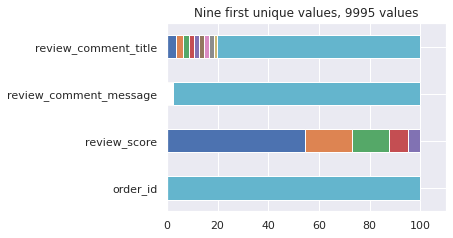

In [81]:
stacked_barchart(new_reviews_df)

In [82]:
merge_df = merge_df.merge(
    new_reviews_df,
    how='left',
    left_on='order_id',
    right_on='order_id'   
    )

In [83]:
temp_order_id = '7144ca093cbdecfdfc3e76d49da6ffb9'

In [84]:
diff_columns = []
for column in merge_df.columns:
    if len(merge_df[merge_df['order_id']==temp_order_id][column].unique()) > 1:
        diff_columns.append(column)

diff_columns.append('order_id')

for column in diff_columns:
    print(column, ': ', len(merge_df[merge_df['order_id']==temp_order_id][column].unique()))

order_id :  1


In [85]:
merge_df.shape

(98686, 45)

### 7 Cas particulier de la geolocalisation

Fusionner directement les dataframes avec geolocation est inenvisageable, car très vorace en temps de calcul.

Or nous souhaitons calculer la distance entre vendeur et acheteur, et l'utiliser dans nos calculs de segmentation. Nous y arriverons en plusieurs étapes :
1.   Former un dataframe temporaire, avec une colonne *order_id*, et une colonne *distance*
2.   Ajouter cette colonne distance au tableau général via une fusion.



**Déclaration des dataframes minimums utiles**

In [86]:
# Attention, dans un premier temps, on prend customer_id
# Dans un deuxième temps, il faudrait idéalement prendre customer_unique_id
temp_cust_df = customers_df[['customer_id',
                             'customer_zip_code_prefix'
                             ]]
temp_geo_df = geolocation_df[['geolocation_zip_code_prefix',
                              'geolocation_lat',
                              'geolocation_lng'
                              ]]
temp_orders_df = orders_df[['order_id',
                            'customer_id',
                            ]]
temp_order_items_df = order_items_df[['order_id',
                                      'seller_id'
                                      ]]
temp_sell_df = sellers_df[['seller_id',
                           'seller_zip_code_prefix'
                           ]]

**Agrégation du dataframe geolocation**

Pour un seul zipcode, il peut y avoir plusieurs couples de coordonnées. Autant que d'habitations, ce qui donne un niveau de détail pas forcément utile.

Nous allons ramener chaque couple de coordonnées au zipcode par la moyenne.

<Figure size 360x176.363 with 0 Axes>

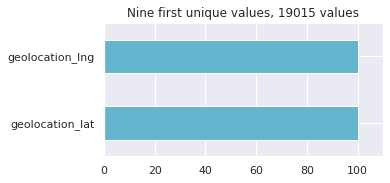

In [87]:
temp_geo_df = temp_geo_df.groupby('geolocation_zip_code_prefix').mean()
stacked_barchart(temp_geo_df)

**Fusion customers - geolocation**

<Figure size 360x249.415 with 0 Axes>

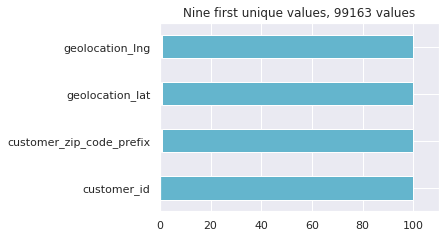

In [88]:
temp_merge_df = temp_cust_df.merge(temp_geo_df,
                                   how='inner',
                                   left_on='customer_zip_code_prefix',
                                   right_on='geolocation_zip_code_prefix',
                                   )
stacked_barchart(temp_merge_df)

In [89]:
temp_merge_df.shape

(99163, 4)

**Fusion merge - orders**

<Figure size 360x278.855 with 0 Axes>

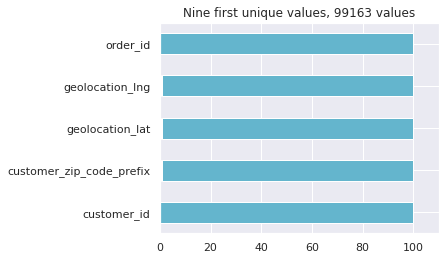

In [90]:
temp_merge_df = temp_merge_df.merge(temp_orders_df,
                                   how='inner',
                                   left_on='customer_id',
                                   right_on='customer_id',
                                   )
stacked_barchart(temp_merge_df)

In [91]:
temp_merge_df.shape

(99163, 5)

**Fusion merge - order items**

<Figure size 360x305.47 with 0 Axes>

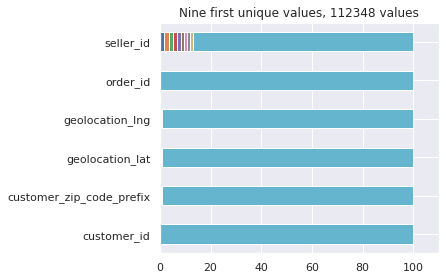

In [92]:
temp_merge_df = temp_merge_df.merge(temp_order_items_df,
                                   how='inner',
                                   left_on='order_id',
                                   right_on='order_id',
                                   )
stacked_barchart(temp_merge_df)

In [93]:
temp_merge_df.drop_duplicates(subset=['order_id'], inplace=True)

In [94]:
temp_merge_df.shape

(98392, 6)

**Fusion merge - sellers**

<Figure size 360x329.945 with 0 Axes>

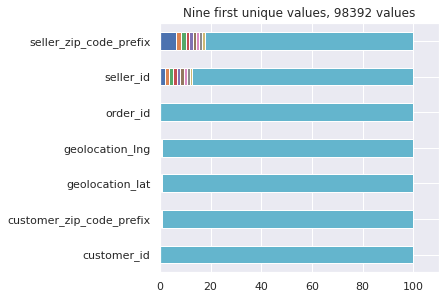

In [95]:
temp_merge_df = temp_merge_df.merge(temp_sell_df,
                                   how='inner',
                                   left_on='seller_id',
                                   right_on='seller_id',
                                   )
stacked_barchart(temp_merge_df)

In [96]:
temp_merge_df.shape

(98392, 7)

**Fusion merge - geolocation**

<Figure size 360x374.123 with 0 Axes>

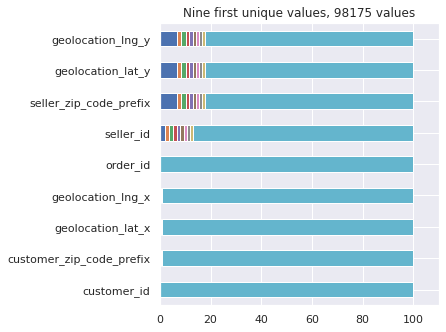

In [97]:
temp_merge_df = temp_merge_df.merge(temp_geo_df,
                                   how='inner',
                                   left_on='seller_zip_code_prefix',
                                   right_on='geolocation_zip_code_prefix',
                                   )
stacked_barchart(temp_merge_df)

In [98]:
temp_merge_df.shape

(98175, 9)

**Suppression des colonnes inutiles**

In [99]:
temp_merge_df.drop(['customer_id',
                    'customer_zip_code_prefix',
                    'seller_id',
                    'seller_zip_code_prefix'
                    ],
                   axis=1,
                   inplace=True
                   )
temp_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98175 entries, 0 to 98174
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   geolocation_lat_x  98175 non-null  float64
 1   geolocation_lng_x  98175 non-null  float64
 2   order_id           98175 non-null  object 
 3   geolocation_lat_y  98175 non-null  float64
 4   geolocation_lng_y  98175 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.5+ MB


In [100]:
# Calcul de la distance
rayon_terre = 6371
phi_x = np.array([math.radians(element) for element in temp_merge_df['geolocation_lat_x']])
phi_y = np.array([math.radians(element) for element in temp_merge_df['geolocation_lat_y']])
theta_x = np.array([math.radians(element) for element in temp_merge_df['geolocation_lng_x']])
theta_y = np.array([math.radians(element) for element in temp_merge_df['geolocation_lng_y']])
# Formule trouvée sur internet
temp_merge_df['distancia'] = rayon_terre * np.arccos(np.sin(phi_x) * np.sin(phi_y)
+ np.cos(phi_x) * np.cos(phi_y) * np.cos(theta_y - theta_x))
#temp_merge_df['distancia'] = math.sqrt((np.float(phi_y - phi_x))**2 +(theta_y - theta_x)**2) * rayon_terre

# Création de la colonne correspondant à la distance
temp_merge_df['distancia'] = [int(element) for element in temp_merge_df['distancia']]

# Suppression des coordonnées, désormais inutiles
temp_merge_df.drop(['geolocation_lat_x',
                    'geolocation_lat_y',
                    'geolocation_lng_x',
                    'geolocation_lng_y'],
                   axis=1,
                   inplace=True)

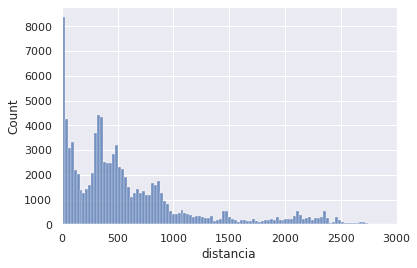

In [101]:
plt.xlim(0, 3000)
sns.histplot(temp_merge_df['distancia'])

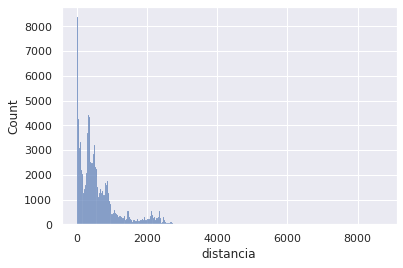

In [102]:
sns.histplot(temp_merge_df['distancia'])

<Figure size 360x845.808 with 0 Axes>

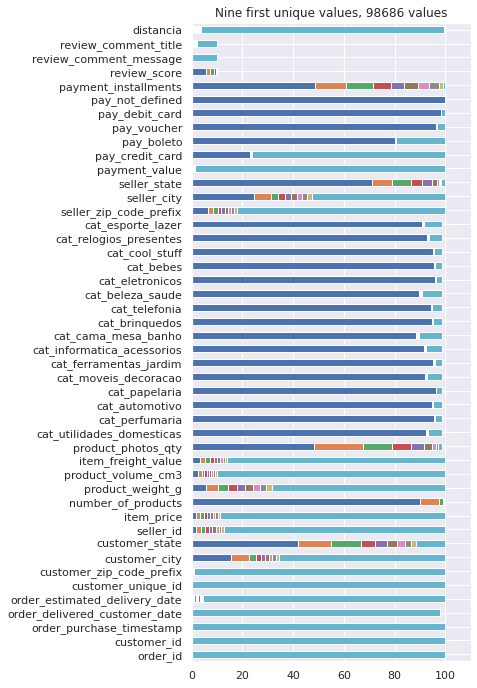

In [103]:
merge_df = merge_df.merge(temp_merge_df,
                          how='left',
                          left_on='order_id',
                          right_on='order_id'
                          )
stacked_barchart(merge_df)

In [104]:
merge_df.shape

(98686, 46)

## C Réduction aux colonnes utiles

### 1 Suppression des colonnes inutiles

In [105]:
merge_df.drop([#'customer_unique_id',
               'customer_zip_code_prefix',
               #'product_id',
               'seller_id',
               'seller_zip_code_prefix',
               'seller_city',
               'seller_state'
               ],
              axis=1,
              inplace=True)

In [106]:
#stacked_barchart(merge_df)

In [107]:
merge_df.head(5)

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,review_comment_message,review_comment_title,distancia
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,NaN,NaN,NaN,18.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,NaN,NaN,NaN,15.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,florianopolis,SC,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,NaN,NaN,NaN,474.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,2017-08-10 13:35:55,2017-08-16 19:03:36,2017-08-23 00:00:00,02c9e0c05a817d4562ec0e8c90f29dba,itaquaquecetuba,SP,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0


### 2 Exploration des nouvelles données

In [108]:
def control_chart(
    my_year,
    x_feature,
    y_feature,
    y_min,
    y_max,
    per_week=True,
    per_month=False,
    quantiles=False,
    my_dataframe=merge_df,
    ):
    # ----------------------------------------
    # Constitution du dataframe d'étude brut
    # ----------------------------------------

    # Sélectionner la colonne utile

    my_dataframe = merge_df[[x_feature,
                        y_feature]]

    # Eliminer les valeurs erratiques
    if quantiles:
        my_dataframe = my_dataframe[my_dataframe[y_feature] < my_dataframe[y_feature].quantile(.99)]
        my_dataframe = my_dataframe[my_dataframe[y_feature] > my_dataframe[y_feature].quantile(.01)]

    # Convertir en format date
    #my_dataframe[x_feature] = my_dataframe[x_feature].dt.date

    # regrouper par date
    my_dataframe = my_dataframe.groupby(
        [x_feature]
        ).mean()

    # Reseter l'index
    my_dataframe = my_dataframe.reset_index()

    # Reconvertir en date
    my_dataframe[x_feature] = pd.to_datetime(
        my_dataframe[x_feature]
    )

    # Sélectionner l'année
    if my_year:
        mask = my_dataframe[x_feature].dt.year == int(my_year)
        my_dataframe = my_dataframe[mask]

    # ----------------------------------------
    # Regroupement
    # ----------------------------------------

    # Paramètre de regroupement

    if per_week:
        # Regrouper par semaine calendaire
        my_dataframe[x_feature] = [
                                            element.isocalendar()[1] for element 
                                            in my_dataframe[x_feature]
                                            ]
        my_dataframe = my_dataframe.groupby(
            [x_feature]
            ).mean()

        # Reseter l'index
        my_dataframe = my_dataframe.reset_index()

    if per_month:
        # Regrouper par mois
        my_dataframe[x_feature] = my_dataframe[x_feature].dt.month
        my_dataframe = my_dataframe.groupby(
            [x_feature]
            ).mean()

        # Reseter l'index
        my_dataframe = my_dataframe.reset_index()

    # Ligne moyenne
    feature_mean = my_dataframe[y_feature].mean()
    my_dataframe['feature_mean'] = [feature_mean] * len(my_dataframe)

    # 6 sigma
    feature_stdev = my_dataframe[y_feature].std()
    my_dataframe['feature_ucl'] = my_dataframe['feature_mean'] + 3 * feature_stdev
    my_dataframe['feature_lcl'] = my_dataframe['feature_mean'] - 3 * feature_stdev

    # ----------------------------------------
    # Représentation graphique
    # ----------------------------------------

    f, ax = plt.subplots(
        figsize=(
            8, 8
            )
        )
    plt.title(
        '{}, année {}'.format(
            y_feature,
            my_year
            )
        )
    plt.xlabel(
        'Semaines calendaires'
    )
    plt.ylabel(
        y_feature
    )
    plt.ylim(
        y_min,
        y_max
        )

    plot_feature = plt.plot(
        my_dataframe[x_feature],
        my_dataframe[y_feature],
        'c',
        linewidth=1,
        marker='o',
        color='k',
        markerfacecolor='orange',
        markersize=8
        )
    plot_mean = plt.plot(
        my_dataframe[x_feature],
        my_dataframe['feature_mean'],
        'k',
        linewidth=3
        )
    plot_ucl = plt.plot(
        my_dataframe[x_feature],
        my_dataframe['feature_ucl'],
        '--',
        color='k'
        )
    plot_lcl = plt.plot(
        my_dataframe[x_feature],
        my_dataframe['feature_lcl'],
        '--',   
        color='k'
        )
    plt.show()

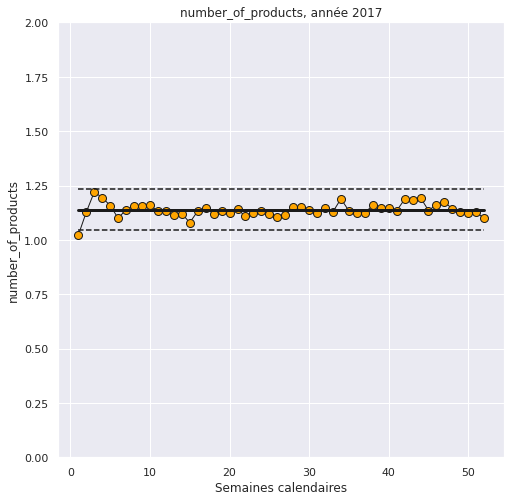

In [109]:
control_chart(
    my_year=2017,
    x_feature='order_purchase_timestamp',
    y_feature='number_of_products',
    y_min=0,
    y_max=2,
    quantiles=False,
)

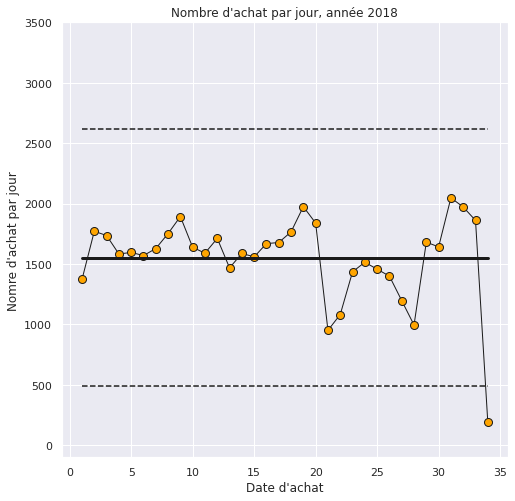

In [110]:
my_year=2018
y_min=-100
y_max=3500
per_week=True,
per_month=False,
quantiles=False,
my_dataframe=merge_df

# ----------------------------------------
# Constitution du dataframe d'étude brut
# ----------------------------------------

# Sélectionner la colonne utile

my_dataframe = merge_df[['order_purchase_timestamp','distancia']]
my_dataframe['count'] = [1] * len(my_dataframe)

# Eliminer les valeurs erratiques
if quantiles:
    my_dataframe = my_dataframe[my_dataframe['order_purchase_timestamp'] < my_dataframe['order_purchase_timestamp'].quantile(.99)]
    my_dataframe = my_dataframe[my_dataframe['order_purchase_timestamp'] > my_dataframe['order_purchase_timestamp'].quantile(.01)]

# Convertir en format date
my_dataframe['order_purchase_timestamp'] = my_dataframe['order_purchase_timestamp'].dt.date

# regrouper par date
my_dataframe = my_dataframe.groupby(
    ['order_purchase_timestamp']
    ).sum()

# Reseter l'index
my_dataframe = my_dataframe.reset_index()

# Reconvertir en date
my_dataframe['order_purchase_timestamp'] = pd.to_datetime(
    my_dataframe['order_purchase_timestamp']
)

# Sélectionner l'année
if my_year:
    mask = my_dataframe['order_purchase_timestamp'].dt.year == int(my_year)
    my_dataframe = my_dataframe[mask]

# ----------------------------------------
# Regroupement
# ----------------------------------------

# Paramètre de regroupement

if per_week:
    # Regrouper par semaine calendaire
    my_dataframe['order_purchase_timestamp'] = [element.isocalendar()[1] for element 
                                                in my_dataframe['order_purchase_timestamp']]
    my_dataframe = my_dataframe.groupby(
        ['order_purchase_timestamp']
        ).sum()

    # Reseter l'index
    my_dataframe = my_dataframe.reset_index()

# Ligne moyenne
feature_mean = my_dataframe['count'].mean()
my_dataframe['feature_mean'] = [feature_mean] * len(my_dataframe)

# 6 sigma
feature_stdev = my_dataframe['count'].std()
my_dataframe['feature_ucl'] = my_dataframe['feature_mean'] + 3 * feature_stdev
my_dataframe['feature_lcl'] = my_dataframe['feature_mean'] - 3 * feature_stdev

# ----------------------------------------
# Représentation graphique
# ----------------------------------------

f, ax = plt.subplots(
    figsize=(
        8, 8
        )
    )
plt.title(
    'Nombre d\'achat par jour, année {}'.format(
        my_year
        )
    )
plt.xlabel(
    'Date d\'achat'
)
plt.ylabel(
    'Nomre d\'achat par jour'
)
plt.ylim(
    y_min,
    y_max
    )

plot_feature = plt.plot(
    my_dataframe['order_purchase_timestamp'],
    my_dataframe['count'],
    'c',
    linewidth=1,
    marker='o',
    color='k',
    markerfacecolor='orange',
    markersize=8
    )
plot_mean = plt.plot(
    my_dataframe['order_purchase_timestamp'],
    my_dataframe['feature_mean'],
    'k',
    linewidth=3
    )
plot_ucl = plt.plot(
    my_dataframe['order_purchase_timestamp'],
    my_dataframe['feature_ucl'],
    '--',
    color='k'
    )
plot_lcl = plt.plot(
    my_dataframe['order_purchase_timestamp'],
    my_dataframe['feature_lcl'],
    '--',   
    color='k'
    )
plt.show()

In [111]:
merge_df.head(5)

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,review_comment_message,review_comment_title,distancia
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,NaN,NaN,NaN,18.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,NaN,NaN,NaN,15.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,florianopolis,SC,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,NaN,NaN,NaN,474.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,2017-08-10 13:35:55,2017-08-16 19:03:36,2017-08-23 00:00:00,02c9e0c05a817d4562ec0e8c90f29dba,itaquaquecetuba,SP,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0


### 3 Extraction des dates et heures utiles

In [112]:
merge_df = date_extraction(
    my_dataframe=merge_df,
    my_column='order_purchase_timestamp',
    my_units=[
              'year',
              'quarter',
              'weekday',
              'month',
              'hour',
              'day',
              'calendar_week',
              'calendar_day'
              ],
    suffix='purch',
    replace=True
)

In [113]:
merge_df = date_extraction(
    my_dataframe=merge_df,
    my_column='order_delivered_customer_date',
    my_units=[
              'weekday',
              'hour',
              ],
    suffix='deliv',
    replace=True
)

In [114]:
merge_df = extract_date(
    merge_df,
    'order_purchase_timestamp',
    'purch',
    True
)

merge_df = extract_date(
    merge_df,
    'order_delivered_customer_date',
    'deliv',
    True
)

merge_df = extract_date(
    merge_df,
    'order_estimated_delivery_date',
    'est_deliv',
    True
)

# Délai de livraison estimé
merge_df['delai_livraison_estime'] = merge_df['Date_est_deliv'] - merge_df['Date_purch']
merge_df['delai_livraison_estime'] = merge_df['delai_livraison_estime'].dt.days

# Retard (ou avance) de livraison constaté(e)
merge_df['retard_livraison'] = merge_df['Date_deliv'] - merge_df['Date_est_deliv']
merge_df['retard_livraison'] = merge_df['retard_livraison'].dt.days

In [115]:
# Constitution du dataframe de comparaison
date_dict = {}
n = 0
length = 10
merge_df_year = merge_df[merge_df['y(2)_purch']==2018]
unique_dates = merge_df_year['Date_purch'].unique()
unique_dates = np.sort(
    unique_dates,
    axis=0
    )

tempo_df = merge_df_year.groupby(
    by='Date_purch'
    ).mean()

important_col = 'h(24)_deliv'

for date_x in unique_dates:
    temp_list = []
    total_x = tempo_df.loc[date_x][important_col]
    for date_y in unique_dates:
        total_y = tempo_df.loc[date_y][important_col]
        temp_list.append(
            abs(
                total_x - total_y
                )
            )
    date_dict[date_x] = temp_list
    n += 1
    #print(round(n/len(unique_dates), 3)*100, '%')

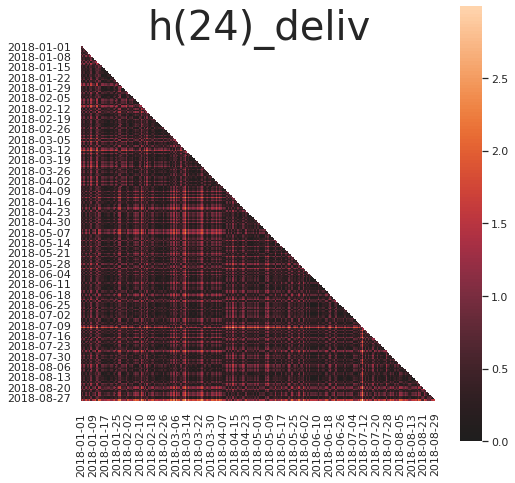

In [116]:
comparison_df = pd.DataFrame(
    data=date_dict,
    index=date_dict.keys()
    )

mask = np.zeros_like(comparison_df)
mask[np.triu_indices_from(
    mask
    )] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(
        figsize=(
            8, 8
            )
        )
    sns.heatmap(
        comparison_df,
        center=0,
        vmin=0,
        #vmax=6000,
        mask=mask,
        square=True
        ).set_title(
            important_col,
            fontsize=40
            )

In [117]:
# Suppression des colonnes de date
merge_df.drop(
    [
     'Date_est_deliv',
     'Date_purch',
     'Date_deliv',
     ],
     axis=1,
     inplace=True
     )

In [118]:
merge_df.head(5)

,order_id,customer_id,customer_unique_id,customer_city,customer_state,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,review_comment_message,review_comment_title,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,NaN,NaN,NaN,18.0,2017,4,0,10,10,2,40,275,1.0,21.0,16,-8.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,NaN,NaN,NaN,15.0,2017,3,1,8,18,15,33,227,4.0,14.0,13,-10.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0,2017,3,2,8,18,2,31,214,0.0,18.0,13,-8.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,e781fdcc107d13d865fc7698711cc572,florianopolis,SC,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,NaN,NaN,NaN,474.0,2017,4,0,10,23,23,43,296,1.0,18.0,21,-6.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,02c9e0c05a817d4562ec0e8c90f29dba,itaquaquecetuba,SP,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0,2017,3,3,8,13,10,32,222,2.0,19.0,13,-7.0


### 4 Etude des clients fidèles

**Estimation de la proportion de clients fidèles**

([<matplotlib.patches.Wedge at 0x7f3dde5cc6d0>,
 [Text(-0.1265763744292064, -1.1933056697411428, 'One-order customers \n 96.6%'),
  Text(0.12657623477253097, 1.1933056845548038, 'Several-orders customers \n 3.4%')])

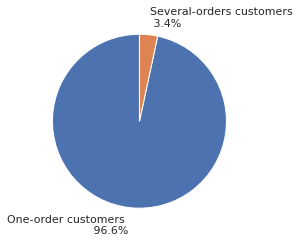

In [119]:
nb_customer_id = len(customers_df['customer_id'].unique())
nb_customer_unique_id = len(customers_df['customer_unique_id'].unique())
values = [nb_customer_unique_id/nb_customer_id*100,
          (nb_customer_id - nb_customer_unique_id)/nb_customer_id*100]
labels = ['One-order customers \n {}%'.format(round(values[0], 1)),
          'Several-orders customers \n {}%'.format(round(values[1], 1))
          ]
plt.pie(
    values,
    labels=labels,
    startangle=90,
    labeldistance=1.2
)

Les clients ayant commandé plusieurs fois sont minoritaires, ils représentent moins de 4% du total des clients.

La fréquence d'achat, l'un des RFM, ne concerne que ces 4%, il n'est donc pas pertinent de l'étudier.

In [120]:
# Dataframe des clients fidèles
faithful_cust_df = merge_df[merge_df['customer_unique_id'].duplicated()==True]
# Dataframe des clients n'ayant commandé qu'un seule fois
oneshot_cust_df = merge_df[merge_df['customer_unique_id'].duplicated()==False]

In [121]:
faithful_cust_df.describe()

,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison
count,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3209.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.0,3266.000000,289.000000,3246.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3266.000000,3176.000000,3176.000000,3266.000000,3176.000000
mean,128.290934,1.205756,2113.869565,15877.848132,19.442538,2.057650,8.381582,4.203571,3.922470,2.027311,8.372761,3.039387,8.077730,12.781789,6.081438,4.402523,11.594866,3.968599,2.956751,4.218008,7.064853,11.518365,151.332453,116.991522,28.575713,4.483157,1.282061,0.0,3.359767,4.083045,570.562230,2017.482854,2.332823,2.816289,5.955909,14.469075,15.463870,24.003980,165.364360,2.101385,16.297544,24.985303,-12.640428
std,184.092328,0.709967,3967.917924,24116.379614,13.911021,1.576279,65.633538,39.503263,27.548257,15.885973,47.261450,24.111935,49.582466,59.571708,44.370576,28.583106,57.316401,41.484238,23.699151,38.544624,55.415491,68.871398,193.363724,186.952097,98.187083,27.947493,14.945328,0.0,3.035284,1.399413,562.002656,0.505874,1.063558,1.969894,3.251936,5.520209,8.641653,14.113486,99.056552,1.593822,5.029169,9.151328,9.996997
min,2.900000,1.000000,50.000000,352.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.560000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,2016.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,-124.000000
25%,43.000000,1.000000,300.000000,3080.000000,13.080000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.857500,24.740000,0.000000,0.000000,0.000000,0.0,1.000000,4.000000,182.000000,2017.000000,1.000000,1.000000,3.000000,11.000000,8.000000,12.000000,80.000000,1.000000,14.000000,20.000000,-17.000000
50%,80.600000,1.000000,750.000000,7200.000000,16.170000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.215000,75.165000,0.000000,0.000000,0.000000,0.0,2.000000,5.000000,419.000000,2017.000000,2.000000,3.000000,6.000000,15.000000,16.000000,23.000000,159.000000,2.000000,17.000000,24.000000,-13.000000
75%,149.000000,1.000000,1813.000000,19092.500000,20.865000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,173.320000,145.532500,0.000000,0.000000,0.000000,0.0,5.000000,5.000000,748.000000,2018.000000,3.000000,4.000000,8.000000,19.000000,23.000000,34.000000,234.000000,3.000000,20.000000,29.000000,-8.000000
max,4799.000000,15.000000,54500.000000,277550.000000,196.940000,15.000000,2600.000000,969.990000,699.990000,295.800000,1199.900000,780.000000,1199.900000,959.990000,1514.300000,699.990000,1020.000000,1369.900000,599.800000,1150.000000,1999.990000,1649.990000,4950.340000,4950.340000,1891.070000,727.880000,315.170000,0.0,21.000000,5.

In [122]:
oneshot_cust_df.describe()

,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison
count,95420.000000,95420.000000,95420.000000,9.542000e+04,95420.000000,94088.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,94139.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.000000,95419.0,95419.000000,9620.000000,94949.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,95420.000000,93320.000000,93320.000000,95420.000000,93320.000000
mean,138.069673,1.139510,2172.134919,1.572361e+04,20.227547,2.256641,8.307422,3.912496,5.416354,3.225771,8.918528,4.392317,9.245981,13.839865,5.425096,5.934142,12.084051,3.352108,4.065863,4.745127,7.998760,10.635923,160.915118,126.347567,28.810319,3.546787,2.210446,0.0,2.917302,3.822765,602.217580,2017.543974,2.354150,2.754800,6.028432,14.785014,15.513613,24.337885,167.579187,2.174014,16.231494,24.387917,-11.850225
std,211.475316,0.531418,3916.407018,2.468834e+04,15.972279,1.745078,61.881186,40.557571,46.927748,33.913639,60.091986,42.643609,60.914742,79.298977,47.195806,53.049305,69.780085,42.049980,57.481476,45.179519,53.507943,66.530446,221.333472,207.622286,111.809892,28.978132,34.960880,0.0,2.702156,1.562448,596.347768,0.504380,1.060388,1.966892,3.229184,5.320895,8.666293,14.045735,98.620868,1.596327,5.227812,8.816334,10.188511
min,0.850000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.590000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,2016.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,-147.000000
25%,45.900000,1.000000,300.000000,2.856000e+03,13.320000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.010000,24.420000,0.000000,0.000000,0.000000,0.0,1.000000,3.000000,185.000000,2017.000000,1.000000,1.000000,3.000000,11.000000,8.000000,13.000000,85.000000,1.000000,14.000000,19.000000,-17.000000
50%,86.900000,1.000000,700.000000,6.650000e+03,16.390000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.380000,77.570000,0.000000,0.000000,0.000000,0.0,2.000000,5.000000,434.000000,2018.000000,2.000000,3.000000,6.000000,15.000000,15.000000,24.000000,162.000000,2.000000,17.000000,24.000000,-12.000000
75%,149.900000,1.000000,1850.000000,1.900800e+04,21.250000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.020000,154.420000,0.000000,0.000000,0.000000,0.0,4.000000,5.000000,800.000000,2018.000000,3.000000,4.000000,8.000000,19.000000,23.000000,34.000000,232.000000,3.000000,20.000000,29.000000,-7.000000
max,13440.000000,21.000000,154200.000000,1.476000e+06,409.680000,20.000000,4400.000000,4599.900000,3597.000000,3099.000000,3549.000000,2874.000000,5934.600000,6499.000000,3124.000000,4399.870000,4099.990000,7160.000000,13440.000000,6735.000000,2740.000000,3099.900000,13664.080000,13664

In [123]:
faithful_cust_df.head(5)

,order_id,customer_id,customer_unique_id,customer_city,customer_state,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,review_comment_message,review_comment_title,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison
61,f7f0b79050e7ef0b1cf7ffceb0aa114a,46fb8cff647939aaf32c4ab5be554501,3edcab192482e9871c17b34cf98c3996,ribeirao das neves,MG,116.9,1,400.0,4693.0,9.33,1.0,0.0,116.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.23,0.00,126.23,0.0,0.0,0.0,1.0,4.0,Chegou atrasado mas está valendo,Bom,17.0,2018,3,5,8,14,4,31,216,1.0,15.0,6,4.0
338,478f37d7f0b12816126177f6d325380b,9e053c9ab0fdd14be294b0023de43c71,10351fa9e690ca750568e3c19978d69e,sao goncalo,RJ,69.0,1,325.0,4410.0,15.36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,84.36,84.36,0.00,0.0,0.0,0.0,4.0,NaN,NaN,NaN,363.0,2018,2,3,6,19,7,23,158,4.0,18.0,27,-19.0
345,04d95724f8e595ca13c0806541d39973,e95994d81b2fd9150bace0cd8a7b8024,9eb77967122094a4eea4084933b47a1e,cotia,SP,130.5,1,463.0,3094.0,7.78,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.28,138.28,0.00,0.0,0.0,0.0,10.0,NaN,NaN,NaN,41.0,2018,1,0,3,10,19,12,78,2.0,18.0,10,-8.0
550,f5a511e584053180df75a3a2138e9ae3,752655de6382f697166ab67dfaa9b8fc,71b14aca95bfbedbc5746d2c0a92d8e2,teresopolis,RJ,170.0,1,4338.0,2856.0,21.68,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,191.68,191.68,0.00,0.0,0.0,0.0,3.0,NaN,NaN,NaN,561.0,2017,4,2,11,20,22,47,326,1.0,19.0,21,6.0
771,a3388b41c73884c10ac3d97882b683a0,f927dbcf7a40dc8cdcdac6cbbf1d5569,6c2f6983a60ac0dc8a9ee65579959538,sao caetano do sul,SP,117.0,1,396.0,2772.0,12.32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.32,129.32,0.00,0.0,0.0,0.0,2.0,NaN,NaN,NaN,304.0,2017,3,3,9,14,28,39,271,4.0,16.0,26,-11.0


In [124]:
temp_col = 'customer_state'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



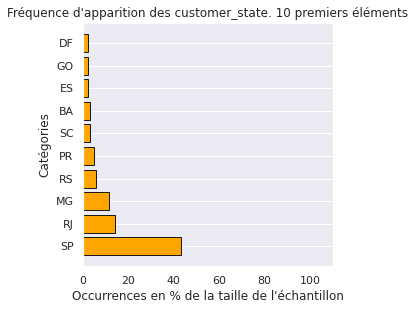

In [125]:
get_pareto(
    faithful_cust_df,
    temp_col,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



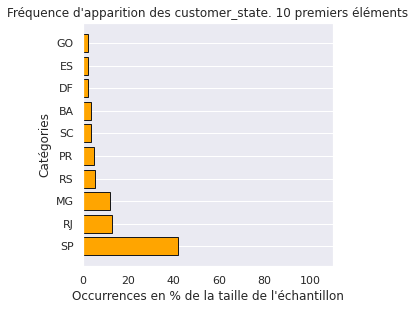

In [126]:
get_pareto(
    oneshot_cust_df,
    temp_col,
)

In [127]:
merge_df.head(5)

,order_id,customer_id,customer_unique_id,customer_city,customer_state,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,review_comment_message,review_comment_title,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,NaN,NaN,NaN,18.0,2017,4,0,10,10,2,40,275,1.0,21.0,16,-8.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,NaN,NaN,NaN,15.0,2017,3,1,8,18,15,33,227,4.0,14.0,13,-10.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0,2017,3,2,8,18,2,31,214,0.0,18.0,13,-8.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,e781fdcc107d13d865fc7698711cc572,florianopolis,SC,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,NaN,NaN,NaN,474.0,2017,4,0,10,23,23,43,296,1.0,18.0,21,-6.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,02c9e0c05a817d4562ec0e8c90f29dba,itaquaquecetuba,SP,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,NaN,NaN,NaN,23.0,2017,3,3,8,13,10,32,222,2.0,19.0,13,-7.0


### 5 Colonnes commentaire

In [128]:
# Encoder les colonnes commentaires
merge_df = encode_reviews(
    merge_df
    )

In [129]:
# Sauvegarde du dataframe original en vue de la modélisation avec k prototype
merge_proto_df = merge_df.copy()

In [130]:
merge_df.head(5)

,order_id,customer_id,customer_unique_id,customer_city,customer_state,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison,m_bem,m_bom,m_mas,m_recomendo,t_bom,t_excelente,t_ótima,t_otimo,t_ótimo,t_recomendado,t_recomendo,t_super
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,NaN,18.0,2017,4,0,10,10,2,40,275,1.0,21.0,16,-8.0,0,0,0,0,0,0,0,0,0,0,0,0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,NaN,15.0,2017,3,1,8,18,15,33,227,4.0,14.0,13,-10.0,0,0,0,0,0,0,0,0,0,0,0,0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,NaN,23.0,2017,3,2,8,18,2,31,214,0.0,18.0,13,-8.0,0,0,0,0,0,0,0,0,0,0,0,0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,e781fdcc107d13d865fc7698711cc572,florianopolis,SC,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,NaN,474.0,2017,4,0,10,23,23,43,296,1.0,18.0,21,-6.0,0,0,0,0,0,0,0,0,0,0,0,0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,02c9e0c05a817d4562ec0e8c90f29dba,itaquaquecetuba,SP,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,NaN,23.0,2017,3,3,8,13,10,32,222,2.0,19.0,13,-7.0,0,0,0,0,0,0,0,0,0,0,0,0


### 6 Encodage des variables catégorielles

In [131]:
# Colonnes à encoder
encode_col = ['customer_city', 'customer_state']

In [132]:
merge_df = encode_me_that(
    merge_df,
    my_code_columns=encode_col
    )

In [133]:
merge_df.head(5)

,order_id,customer_id,customer_unique_id,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison,m_bem,m_bom,m_mas,m_recomendo,t_bom,t_excelente,t_ótima,t_otimo,t_ótimo,t_recomendado,t_recomendo,t_super,x0_sao_paulo,x0_rio_de_janeiro,x0_belo_horizonte,x0_brasilia,x1_SP,x1_SC,x1_PR,x1_RJ,x1_MG,x1_RS,x1_BA,x1_GO,x1_DF,x1_ES
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,NaN,18.0,2017,4,0,10,10,2,40,275,1.0,21.0,16,-8.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,3a51803cc0d012c3b5dc8b7528cb05f7,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,NaN,15.0,2017,3,1,8,18,15,33,227,4.0,14.0,13,-10.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,ef0996a1a279c26e7ecbd737be23d235,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,NaN,23.0,2017,3,2,8,18,2,31,214,0.0,18.0,13,-8.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,e781fdcc107d13d865fc7698711cc572,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,NaN,474.0,2017,4,0,10,23,23,43,296,1.0,18.0,21,-6.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,02c9e0c05a817d4562ec0e8c90f29dba,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,NaN,23.0,2017,3,3,8,13,10,32,222,2.0,19.0,13,-7.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Renommer les colonnes encodées**

In [134]:
# Colonnes relatives aux villes
city_list = [column for column in merge_df.columns 
            if len(column) > 4 
            and column[:2] == 'x0']
state_list = [column for column in merge_df.columns 
            if column[:2] == 'x1']

for column in city_list:
    merge_df.rename(
        columns={
            column:'cit_' + column[3:]
            },
            inplace=True
    )

for column in state_list:
    merge_df.rename(
        columns={
            column:'sta_' + column[3:]
            },
            inplace=True
    )

In [135]:
merge_df.describe()

,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison,m_bem,m_bom,m_mas,m_recomendo,t_bom,t_excelente,t_ótima,t_otimo,t_ótimo,t_recomendado,t_recomendo,t_super,cit_sao_paulo,cit_rio_de_janeiro,cit_belo_horizonte,cit_brasilia,sta_SP,sta_SC,sta_PR,sta_RJ,sta_MG,sta_RS,sta_BA,sta_GO,sta_DF,sta_ES
count,98686.000000,98686.000000,98686.000000,9.868600e+04,98686.000000,97297.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,97337.000000,98685.000000,98685.000000,98685.000000,98685.000000,98685.000000,98685.0,98685.000000,9909.000000,98195.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,96496.000000,96496.000000,98686.000000,96496.000000,98686.000000,98686.000000,98686.00000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.000000,98686.00000
mean,137.746047,1.141702,2170.206635,1.572871e+04,20.201567,2.250078,8.309858,3.922059,5.367272,3.186395,8.900597,4.347866,9.207598,13.805102,5.446660,5.883820,12.067979,3.372363,4.029424,4.727809,7.968077,10.664916,160.597978,126.037926,28.802554,3.577776,2.179721,0.0,2.931945,3.830356,601.171159,2017.541951,2.353444,2.756835,6.026032,14.774558,15.511967,24.326835,167.505887,2.171624,16.233668,24.407687,-11.876233,0.006941,0.006303,0.00535,0.003618,0.005391,0.000719,0.000274,0.001034,0.000527,0.001125,0.009312,0.003506,0.156111,0.069260,0.027866,0.021442,0.419340,0.036601,0.050676,0.129350,0.117007,0.055043,0.034027,0.020337,0.021533,0.02052
std,210.632486,0.538402,3918.116121,2.466952e+04,15.908893,1.740128,62.007723,40.523203,46.420431,33.476581,59.714139,42.164969,60.576258,78.729401,47.105605,52.427809,69.405968,42.031447,56.692581,44.977009,53.571660,66.608486,220.470386,206.977139,111.385268,28.944957,34.485204,0.0,2.714972,1.558486,595.268297,0.504545,1.060494,1.967012,3.229949,5.327882,8.665440,14.048038,98.635609,1.596289,5.221382,8.828223,10.183190,0.083025,0.079140,0.07295,0.060037,0.073225,0.026813,0.016539,0.032133,0.022949,0.033519,0.096051,0.059108,0.362963,0.253897,0.164590,0.144852,0.493454,0.187781,0.219336,0.335588,0.321431,0.228066,0.181300,0.141152,0.145153,0.14177
min,0.850000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.590000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,2016.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,-147.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,45.900000,1.000000,300.000000,2.856000e+03,13.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,24.420000,0.000000,0.0000

In [136]:
merge_df.shape

(98686, 72)

## D Traitement des valeurs NaN

In [137]:
brazil_north_to_south = 4395

fill_dict = {
    'product_photos_qty':0,
    'review_score':3,
    'distancia':brazil_north_to_south/2,
    'wd(7)_deliv':2,
    'h(24)_deliv':18,
    'retard_livraison':-8
    }
merge_df.fillna(
    value=fill_dict,
    inplace=True
    )
merge_proto_df.fillna(
    value=fill_dict,
    inplace=True
    )

## E Traitement des colonnes encodées

In [138]:
merge_df.head(5)

,order_id,customer_id,customer_unique_id,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison,m_bem,m_bom,m_mas,m_recomendo,t_bom,t_excelente,t_ótima,t_otimo,t_ótimo,t_recomendado,t_recomendo,t_super,cit_sao_paulo,cit_rio_de_janeiro,cit_belo_horizonte,cit_brasilia,sta_SP,sta_SC,sta_PR,sta_RJ,sta_MG,sta_RS,sta_BA,sta_GO,sta_DF,sta_ES
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,3.0,18.0,2017,4,0,10,10,2,40,275,1.0,21.0,16,-8.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,3a51803cc0d012c3b5dc8b7528cb05f7,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,3.0,15.0,2017,3,1,8,18,15,33,227,4.0,14.0,13,-10.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,ef0996a1a279c26e7ecbd737be23d235,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,3.0,23.0,2017,3,2,8,18,2,31,214,0.0,18.0,13,-8.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,e781fdcc107d13d865fc7698711cc572,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,3.0,474.0,2017,4,0,10,23,23,43,296,1.0,18.0,21,-6.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,02c9e0c05a817d4562ec0e8c90f29dba,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,3.0,23.0,2017,3,3,8,13,10,32,222,2.0,19.0,13,-7.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


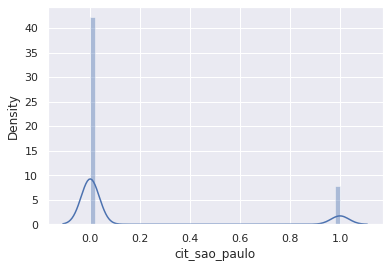

In [139]:
sns.distplot(
    merge_df['cit_sao_paulo']
)

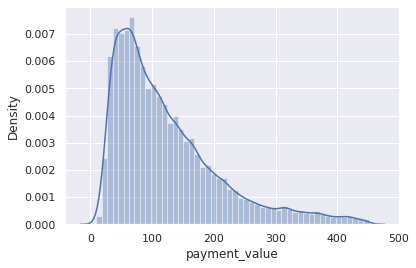

In [140]:
sns.distplot(
    merge_df[merge_df['payment_value']< merge_df['payment_value'].quantile(0.95)]['payment_value']
)

In [141]:
# Voir les corrélations entre colonnes par une heatmap
if False:
    corr = merge_df.corr()
    g, ax = plt.subplots(figsize=(15,15))
    matrix = np.triu(corr)
    sns.heatmap(corr,linewidths=0.1,square=True,mask=matrix)
    plt.tick_params(labelsize=8)

In [142]:
# Colonnes de commentaire : 'm_...' ou 't_...'
for column in merge_df.columns:
    if column[:2] == 'm_' or column[:2] == 't_':
        merge_df[column] = merge_df[column] * merge_df['review_score']
# Dataframe destiné au k-prototype
for column in merge_proto_df.columns:
    if column[:2] == 'm_' or column[:2] == 't_':
        merge_proto_df[column] = merge_proto_df[column] * merge_proto_df['review_score']

In [143]:
# Colonnes de ville ou d'état fédéral : 'cit_...' ou 'sta_...'
for column in merge_df.columns:
    if column[:4] == 'cit_' or column[:4] == 'sta_':
        merge_df[column] = merge_df[column] * merge_df['payment_value']

In [144]:
merge_df.head(5)

,order_id,customer_id,customer_unique_id,item_price,number_of_products,product_weight_g,product_volume_cm3,item_freight_value,product_photos_qty,cat_utilidades_domesticas,cat_perfumaria,cat_automotivo,cat_papelaria,cat_moveis_decoracao,cat_ferramentas_jardim,cat_informatica_acessorios,cat_cama_mesa_banho,cat_brinquedos,cat_telefonia,cat_beleza_saude,cat_eletronicos,cat_bebes,cat_cool_stuff,cat_relogios_presentes,cat_esporte_lazer,payment_value,pay_credit_card,pay_boleto,pay_voucher,pay_debit_card,pay_not_defined,payment_installments,review_score,distancia,y(2)_purch,q(4)_purch,wd(7)_purch,m(12)_purch,h(24)_purch,d(31)_purch,cw(52)_purch,cd(365)_purch,wd(7)_deliv,h(24)_deliv,delai_livraison_estime,retard_livraison,m_bem,m_bom,m_mas,m_recomendo,t_bom,t_excelente,t_ótima,t_otimo,t_ótimo,t_recomendado,t_recomendo,t_super,cit_sao_paulo,cit_rio_de_janeiro,cit_belo_horizonte,cit_brasilia,sta_SP,sta_SC,sta_PR,sta_RJ,sta_MG,sta_RS,sta_BA,sta_GO,sta_DF,sta_ES
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,29.99,1,500.0,1976.0,8.72,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,18.12,0.00,20.59,0.0,0.0,1.0,3.0,18.0,2017,4,0,10,10,2,40,275,1.0,21.0,16,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.71,0.0,0.0,0.0,38.71,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,3a51803cc0d012c3b5dc8b7528cb05f7,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,3.0,3.0,15.0,2017,3,1,8,18,15,33,227,4.0,14.0,13,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,0.0,0.0,0.0,37.77,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,ef0996a1a279c26e7ecbd737be23d235,29.99,1,500.0,1976.0,7.78,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,37.77,0.00,0.00,0.0,0.0,1.0,3.0,23.0,2017,3,2,8,18,2,31,214,0.0,18.0,13,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.77,0.0,0.0,0.0,37.77,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,e781fdcc107d13d865fc7698711cc572,29.99,1,500.0,1976.0,14.10,4.0,29.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.09,0.00,44.09,0.00,0.0,0.0,1.0,3.0,474.0,2017,4,0,10,23,23,43,296,1.0,18.0,21,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,44.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,02c9e0c05a817d4562ec0e8c90f29dba,75.90,1,238.0,3000.0,7.79,3.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,0.0,0.0,0.0,0.0,0.0,83.69,83.69,0.00,0.00,0.0,0.0,1.0,3.0,23.0,2017,3,3,8,13,10,32,222,2.0,19.0,13,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,83.69,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


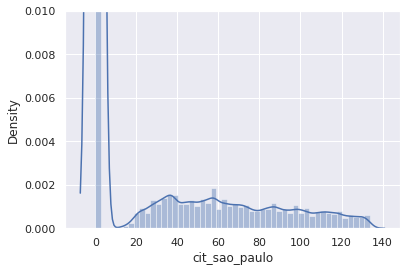

In [145]:
plt.ylim((0, 0.01))
sns.distplot(
    merge_df[merge_df['cit_sao_paulo']< merge_df['cit_sao_paulo'].quantile(0.95)]['cit_sao_paulo']
)

# VI.  Clustering

## A Fonctions

### 1 Dendrogramme

In [147]:
 def plot_dendrogram(Z, names):
    ''' Plot the relations between individuals by displaying a dendrogram of 
    the dataset.'''
    
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(Z,
               labels = names,
               orientation = "left",
               leaf_rotation=90,
               )
    plt.show()

In [148]:
def dendrogram(
    my_dataframe
):
    fig = ff.create_dendrogram(
        my_dataframe
        )
    fig.update_layout(
        width=1600,
        height=500
        )
    fig.show()

In [149]:
def dendrogram_3(
    my_dataframe
):
    Z = hierarchy.linkage(
        my_dataframe,
        'single'
        )
    plt.figure()
    dn = hierarchy.dendrogram(
        Z,
        leaf_rotation=90,
        no_labels=True
        )
    return dn['color_list']

### 2 k-means

In [150]:
def k_means(
    my_data,
    n_clust
    ):
    ''' Returns a visualisation of a cloud of points,
    k-mean model.'''
    
    data_ = np.array(
        my_data
        )

    # Instanciation, fit et predict
    km = KMeans(
        n_clusters=n_clust
        )

    y_km = km.fit_predict(
        data_
        )

    # Plot the clusters
    for i in range(n_clust):
        plt.scatter(
            data_[y_km == i, 0],
            data_[y_km == i, 1],
            s=50,
            edgecolor='k',
            label='cluster {}'.format(i)
        )

    # Plot the centroids
    plt.scatter(
        km.cluster_centers_[:, 0],
        km.cluster_centers_[:, 1],
        s=250,
        marker='*',
        c='red',
        edgecolor='k',
        label='centroids'
    )

    # Finition
    plt.legend(
        scatterpoints=1
        )
    plt.grid()
    plt.title(
        "K-means, pour {} individus".format(
            len(
                data_
                )
            )
        )
    plt.show(
        block=False
        )

### 3 Sélection des colonnes selon la date d'achat

In [151]:
def temporal_filter(
    my_dataframe,
    my_unit,
    my_value
):
    ''' Filtrer les données selon le moment d'achat. '''
    
    if my_unit == 'year':
        my_dataframe_ = my_dataframe[my_dataframe['y(2)_purch']==my_value]
    if my_unit == 'quarter':
        my_dataframe_ = my_dataframe[my_dataframe['q(4)_purch']==my_value]
    if my_unit == 'weekday':
        my_dataframe_ = my_dataframe[my_dataframe['wd(7)_purch']==my_value]
    if my_unit == 'month':
        my_dataframe_ = my_dataframe[my_dataframe['m(12)_purch']==my_value]
    if my_unit == 'hour':
        my_dataframe_ = my_dataframe[my_dataframe['h(24)_purch']==my_value]
    if my_unit == 'day':
        my_dataframe_ = my_dataframe[my_dataframe['d(31)_purch']==my_value]
    if my_unit == 'calendar_week':
        my_dataframe_ = my_dataframe[my_dataframe['cw(52)_purch']==my_value]
    if my_unit == 'calendar_day':
        my_dataframe_ = my_dataframe[my_dataframe['cd(365)_purch']==my_value]

    return my_dataframe_

In [152]:
# Filtrer sur l'année
merge_temp_df = temporal_filter(
    merge_df,
    'year',
    2018
)
# Filtrer sur le trimestre
merge_temp_df = temporal_filter(
    merge_temp_df,
    'quarter',
    1
)

In [153]:
len(merge_temp_df)

21102

## B Préparation

### 1 Passage au log

In [154]:
log_columns = [
               'item_freight_value',
               'item_price',
               'payment_value',
               'product_volume_cm3',
               'product_weight_g',
               ]
merge_temp_df = log_transform(
    merge_df,
    cols=log_columns
    )
merge_proto_df = log_transform(
    merge_proto_df,
    cols=log_columns
    )

### 2 StandardScaler

In [155]:
def glob_std_scal(
    my_dataframe,
    six_sigma_cols,
    minmax_cols
):
    """
        Apply standard scale to given columns, minmax scale to others.
    """

    # Pré-traitement
    my_dataframe.reset_index(
        inplace=True
    )
    my_dataframe.drop(
        'index',
        axis=1,
        inplace=True
    )

    # Dissociate the dataframe to scale from the dataframe not to scale
    # Colonnes dont la dispersion 6 sigma est ramenée à l'intervalle [-1, 1], centrée en 0
    temp_df_1 = my_dataframe[six_sigma_cols]
    # Colonnes ramenées à l'intervalle [0, 1], pas de vrai zéro
    # A priori, la distribution n'est pas gaussienne
    temp_df_2 = my_dataframe[minmax_cols]

    # Standardscale the corresponding columns
    temp_df_1 = standard_scaler(
        temp_df_1,
        six_sigma_cols,
        'std'
        )

    temp_df_2 = standard_scaler(
        temp_df_2,
        minmax_cols,
        'minmax'
        )

    # Merge
    temp_df_ = pd.merge(
        temp_df_1,
        temp_df_2,
        left_index=True,
        right_index=True
    )

    # Remove NaN values (around 600)
    temp_df_ = temp_df_.dropna()

    return temp_df_

In [156]:
# Colonnes dont la dispersion 6 sigma est ramenée à l'intervalle [-1, 1], centrée en 0
std_scale_col = [
                 'distancia',
                 'delai_livraison_estime',
                 'retard_livraison',
                 'log(item_freight_value)',
                 'log(item_price)',
                 'log(payment_value)',
                 'log(product_volume_cm3)',
                 'log(product_weight_g)'
]
# Colones dont la dispersion totale est ramenée à l'intervalle [0, 1]
minmax_col = list(
    set(
        [element for element in merge_df.columns
         if element not in std_scale_col]
    )
)
# Enlever les colonnes d'index
minmax_col.remove('order_id')
minmax_col.remove('customer_id')
minmax_col.remove('customer_unique_id')

In [157]:
# Appliquer le standard scaler et le minmax scaler
merge_df = glob_std_scal(
    merge_df,
    std_scale_col,
    minmax_col
)

In [158]:
merge_df.head(5)

,distancia,delai_livraison_estime,retard_livraison,log(item_freight_value),log(item_price),log(payment_value),log(product_volume_cm3),log(product_weight_g),cat_eletronicos,h(24)_deliv,cat_cool_stuff,sta_GO,t_excelente,cat_telefonia,cat_bebes,pay_debit_card,review_score,sta_SP,cat_cama_mesa_banho,cat_esporte_lazer,sta_MG,y(2)_purch,sta_ES,number_of_products,t_recomendado,m_recomendo,cit_belo_horizonte,cit_brasilia,t_ótima,t_super,m_bem,pay_boleto,cd(365)_purch,sta_PR,cw(52)_purch,cat_ferramentas_jardim,t_ótimo,d(31)_purch,sta_RJ,sta_BA,t_bom,m_mas,cat_relogios_presentes,cat_papelaria,pay_credit_card,t_otimo,payment_installments,sta_SC,cit_sao_paulo,cit_rio_de_janeiro,pay_voucher,t_recomendo,cat_moveis_decoracao,pay_not_defined,sta_RS,cat_brinquedos,m_bom,product_photos_qty,cat_utilidades_domesticas,h(24)_purch,cat_informatica_acessorios,m(12)_purch,q(4)_purch,sta_DF,cat_perfumaria,wd(7)_deliv,cat_automotivo,cat_beleza_saude,wd(7)_purch
0,-0.978159,-0.952369,0.375801,-1.328811,-1.117183,-1.280859,-0.994454,-0.376597,0.0,0.913043,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005755,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.752747,0.0,0.764706,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.001326,0.0,0.041667,0.000000,0.008577,0.0,0.011196,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.434783,0.0,0.818182,1.000000,0.0,0.0,0.166667,0.0,0.000000,0.000000
1,-0.983123,-1.292190,0.177500,-1.549461,-1.117183,-1.311220,-0.994454,-0.376597,0.0,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005615,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.620879,0.0,0.627451,0.0,0.0,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.002764,0.0,0.125000,0.000000,0.008369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.782609,0.0,0.636364,0.666667,0.0,0.0,0.666667,0.0,0.000000,0.166667
2,-0.969885,-1.292190,0.375801,-1.549461,-1.117183,-1.311220,-0.994454,-0.376597,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005615,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.585165,0.0,0.588235,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.002764,0.0,0.041667,0.000000,0.008369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.782609,0.0,0.636364,0.666667,0.0,0.0,0.000000,0.0,0.000000,0.333333
3,-0.223582,-0.386001,0.574102,-0.399192,-1.117183,-1.120138,-0.994454,-0.376597,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006061,0.810440,0.0,0.823529,0.0,0.0,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.012025,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,1.000000,0.0,0.818182,1.000000,0.0,0.0,0.166667,0.0,0.000000,0.000000
4,-0.969885,-1.292190,0.474952,-1.546977,-0.122300,-0.328619,-0.670360,-0.931054,0.0,0.826087,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.012442,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.607143,0.0,0.607843,0.0,0.0,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.006125,0.0,0.041667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.000000,0.565217,0.0,0.636364,0.666667,0.0,0.0,0.333333,0.0,0.018512,0.500000


**Traitement spécial pour le dataframe destiné à la modélisation k-prototype**

In [159]:
if False:
    # Sélection des colonnes destinées au min max scaler
    minmax_proto_col = list(
        set(
            [element for element in merge_proto_df.columns
            if element not in std_scale_col]
        )
    )
    # Enlever les colonnes non quantitatives
    minmax_proto_col.remove('order_id')
    minmax_proto_col.remove('customer_id')
    minmax_proto_col.remove('customer_city')
    minmax_proto_col.remove('customer_state')

    # Sauvegarder les colonnes catégorielles
    temp_df = merge_proto_df[['customer_city','customer_state']]

    # Appliquer le standard scaler et le minmax scaler
    merge_proto_df = glob_std_scal(
        merge_proto_df,
        std_scale_col,
        minmax_proto_col
    )
    # Récupérer via une jointure les colonnes de ville et d'état
    merge_proto_df = pd.merge(
        merge_proto_df,
        temp_df,
        left_index=True,
        right_index=True
    )

## C Visualisations

### 1 PCA

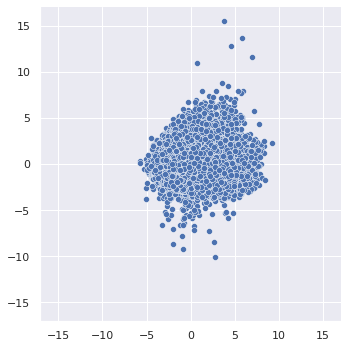

In [160]:
draw_pca_n_dimensions(
    merge_df,
    merge_df.shape[1]
    )

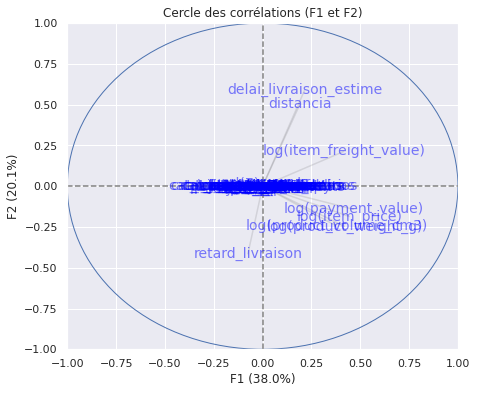

In [161]:
draw_pca_circle(
    merge_df,
    merge_df.shape[1]
    )

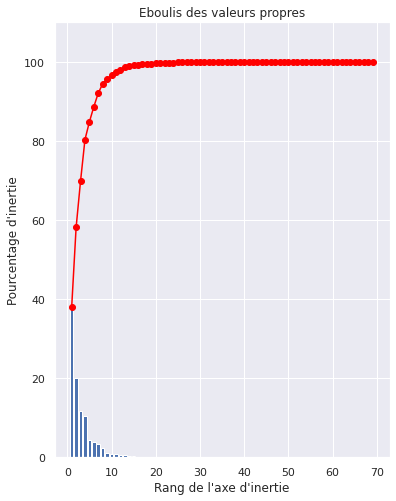

In [162]:
display_scree_plot(
    data=merge_df,
    n_comp=merge_df.shape[1]
    )

**Réduction à l'aide du PCA**

In [163]:
def pca_reduction(
    my_dataframe,
    nb_col
):
    # Extraction des valeurs d'inertie
    my_scree = scree(
        my_dataframe,
        my_dataframe.shape[1]
        )

    # Affectation des valeurs aux noms de features
    scree_df = pd.DataFrame({
        'feature':my_dataframe.columns,
        'value':my_scree
        }
        )

    # Extraction des n features les plus importantes
    best_scree_col = scree_df.sort_values(
        by='value',
        ascending=False,
        )['feature'][:nb_col]

    my_dataframe = my_dataframe[best_scree_col]

    return my_dataframe

In [164]:
merge_pca_df = pca_reduction(merge_df, 10)

### 2 t-SNE

In [165]:
if False:
    embedded_df = TSNE(
        n_components=2
        ).fit_transform(
            merge_pca_df.sample(
                frac=0.1
                )
        )
    df_subset = pd.DataFrame(
        embedded_df[:, 0],
        embedded_df[:, 1]
        )
    sns.scatterplot(
        data=df_subset
        )

### 3 Dendrogramme

In [166]:
if False:
    my_list = dendrogram_3(
        frac_pca_df[:1000]
        )

In [167]:
#Counter(my_list)

## D Modélisations

In [168]:
fraction_value = 0.1
frac_pca_df = merge_pca_df.sample(
    frac=fraction_value
    )
frac_df = merge_df.sample(
    frac=fraction_value
    )
temp_df = merge_df

In [169]:
temp_df.head(5)

,distancia,delai_livraison_estime,retard_livraison,log(item_freight_value),log(item_price),log(payment_value),log(product_volume_cm3),log(product_weight_g),cat_eletronicos,h(24)_deliv,cat_cool_stuff,sta_GO,t_excelente,cat_telefonia,cat_bebes,pay_debit_card,review_score,sta_SP,cat_cama_mesa_banho,cat_esporte_lazer,sta_MG,y(2)_purch,sta_ES,number_of_products,t_recomendado,m_recomendo,cit_belo_horizonte,cit_brasilia,t_ótima,t_super,m_bem,pay_boleto,cd(365)_purch,sta_PR,cw(52)_purch,cat_ferramentas_jardim,t_ótimo,d(31)_purch,sta_RJ,sta_BA,t_bom,m_mas,cat_relogios_presentes,cat_papelaria,pay_credit_card,t_otimo,payment_installments,sta_SC,cit_sao_paulo,cit_rio_de_janeiro,pay_voucher,t_recomendo,cat_moveis_decoracao,pay_not_defined,sta_RS,cat_brinquedos,m_bom,product_photos_qty,cat_utilidades_domesticas,h(24)_purch,cat_informatica_acessorios,m(12)_purch,q(4)_purch,sta_DF,cat_perfumaria,wd(7)_deliv,cat_automotivo,cat_beleza_saude,wd(7)_purch
0,-0.978159,-0.952369,0.375801,-1.328811,-1.117183,-1.280859,-0.994454,-0.376597,0.0,0.913043,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005755,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.752747,0.0,0.764706,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.001326,0.0,0.041667,0.000000,0.008577,0.0,0.011196,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.434783,0.0,0.818182,1.000000,0.0,0.0,0.166667,0.0,0.000000,0.000000
1,-0.983123,-1.292190,0.177500,-1.549461,-1.117183,-1.311220,-0.994454,-0.376597,0.0,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005615,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.620879,0.0,0.627451,0.0,0.0,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.002764,0.0,0.125000,0.000000,0.008369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.782609,0.0,0.636364,0.666667,0.0,0.0,0.666667,0.0,0.000000,0.166667
2,-0.969885,-1.292190,0.375801,-1.549461,-1.117183,-1.311220,-0.994454,-0.376597,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005615,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.585165,0.0,0.588235,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.002764,0.0,0.041667,0.000000,0.008369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.782609,0.0,0.636364,0.666667,0.0,0.0,0.000000,0.0,0.000000,0.333333
3,-0.223582,-0.386001,0.574102,-0.399192,-1.117183,-1.120138,-0.994454,-0.376597,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006061,0.810440,0.0,0.823529,0.0,0.0,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.012025,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,1.000000,0.0,0.818182,1.000000,0.0,0.0,0.166667,0.0,0.000000,0.000000
4,-0.969885,-1.292190,0.474952,-1.546977,-0.122300,-0.328619,-0.670360,-0.931054,0.0,0.826087,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.012442,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.607143,0.0,0.607843,0.0,0.0,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.006125,0.0,0.041667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.000000,0.565217,0.0,0.636364,0.666667,0.0,0.0,0.333333,0.0,0.018512,0.500000


### 1 Locally Linear Embedding

In [170]:
if False:
    embedding = LocallyLinearEmbedding(
        n_components=2
        )
    df_transformed = embedding.fit_transform(
        frac_pca_df
        )
    sns.scatterplot(
        df_transformed[:, 1],
        df_transformed[:, 0]
        )

In [171]:
if False:
    embedding.nbrs_

### 2 Multi-dimensional scaling

In [172]:
if False:
    embedding = MDS(
        n_components=2
        )
    df_transformed = embedding.fit_transform(
        frac_pca_df
        )
    sns.scatterplot(
        df_transformed[:, 1],
        df_transformed[:, 0]
        )

In [173]:
if False:
    embedding.dissimilarity_matrix_

### 3 k-means

In [174]:
if False:
    k_means(
        my_data=temp_df,
        n_clust=8
        )

### 4 k-means prototype

"*Instead of calculating the within sum of squares errors (WSSE) with Euclidian distance, K-Prototype provides the cost function that combines the calculation for numerical and categorical variables.*"

Source : https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

In [175]:
# Get the position of categorical columns
catColumnsPos = [merge_proto_df.columns.get_loc(
    col
    ) for col in list(
        merge_proto_df.select_dtypes('object').columns
            )
    ]
print('Categorical columns           : {}'.format(
    list(
        merge_proto_df.select_dtypes(
            'object'
            ).columns
         )
    )
)
print('Categorical columns position  : {}'.format(
    catColumnsPos
    )
)

Categorical columns           : ['order_id', 'customer_id', 'customer_unique_id', 'customer_city', 'customer_state']
Categorical columns position  : [0, 1, 2, 3, 4]


In [176]:
frac_proto_df = merge_proto_df.sample(
    frac=0.1
    )
# Deux itérations : 50 min !
if False:
    # Convert dataframe to matrix
    dfMatrix = frac_proto_df.to_numpy()

    # Choose optimal K using Elbow method
    #cost = []
    #for cluster in range(1, 10):
    kprototype = KPrototypes(
        n_jobs=-1,
        n_clusters=8,
        init='Huang',
        random_state=0
        )
    kprototype.fit_predict(
        dfMatrix,
        categorical=catColumnsPos
        )
    print(
        'Cluster initiation: {}'.format(
            8
            )
        )

    # Converting the results into a dataframe and plotting them
    df_cost = pd.DataFrame(
        {
        'Cluster':range(1, 10),
        'Cost':kprototype.cost_
        }
        )

    # Data viz
    plotnine.options.figure_size = (8, 4.8)
    (
        ggplot(
            data=df_cost
            )+
        geom_line(aes(x = 'Cluster',
                    y = 'Cost'))+
        geom_point(aes(x = 'Cluster',
                    y = 'Cost'))+
        geom_label(aes(x = 'Cluster',
                    y = 'Cost',
                    label = 'Cluster'),
                size = 10,
                nudge_y = 1000) +
        labs(title = 'Optimal number of cluster with Elbow Method')+
        xlab('Number of Clusters k')+
        ylab('Cost')+
        theme_minimal()
    )

### 5 DBSCAN

In [177]:
if False:
    dbscan_clustering = DBSCAN(
        eps=0.5, 
        min_samples=5,
        leaf_size=30
    ).fit(
        temp_df
    )
    dbscan_clustering.labels_

In [178]:
if False:
    dbscan_clustering

## E Optimisations

### 1 k_means

**Paramètres**

In [179]:
# Intervalle d'essai du nombre de clusters
pnt_nb_min = 3
pnt_nb_max = 15
# Autres hyperparamètres
n_init_ = 8
max_iter_ = 360
tol_ = 0.00005

**Algorithme**

In [180]:
if False:
    inertia_dict = {}
    silhouette_dict = {}
    calinski_harabasz_dict = {}
    davies_bouldin_dict = {}

    for n_clust in range(pnt_nb_min, pnt_nb_max):
        print(n_clust)
        kmeans_model = KMeans(
            n_clusters=n_clust,
            n_init=n_init_,
            max_iter=max_iter_,
            tol=tol_,
            random_state=1
            ).fit(
                temp_df
                )

        labels = kmeans_model.labels_

        # Inertie propre au k-means
        inertia_dict[n_clust] = kmeans_model.inertia_

        # Coefficient de Silhouette
        if False:
            silhouette_dict[n_clust] = metrics.silhouette_score(
                temp_df,
                labels,
                metric='euclidean'
                )

        # Coefficient de Calinksi-Harabasz
        calinski_harabasz_dict[n_clust] = metrics.calinski_harabasz_score(
            temp_df,
            labels
            )
        
        # Coefficient de Davies-Bouldin
        davies_bouldin_dict[n_clust] = metrics.davies_bouldin_score(
            temp_df,
            labels
            )

**Inertie**

In [181]:
if False:
    plt.title('Inertia according number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    inertia_values = inertia_dict.values()
    plt.ylim(0, max(inertia_dict.values())*1.1)
    plt.plot(
        range(pnt_nb_min, pnt_nb_max),
        list(inertia_values)
        )

**Coefficient de Silhouette**

In [182]:
if False:
    plt.title('Performances according Silhouette metrics')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    silh_values = silhouette_dict.values()
    plt.ylim(0, 1)
    plt.plot(
        range(pnt_nb_min, pnt_nb_max),
        list(silh_values)
        )

**Coefficient de Calinski-Harabasz**

In [183]:
if False:
    plt.title('Performances according Calinski-Harabasz metrics')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    calhar_values = calinski_harabasz_dict.values()
    plt.ylim(0, max(calinski_harabasz_dict.values())*1.1)
    plt.plot(
        range(pnt_nb_min, pnt_nb_max),
        list(calhar_values)
        )

**Coefficient de Davies-Bouldin**

In [184]:
if False:
    plt.title('Performances according Davies-Bouldin metrics')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    davbol_values = davies_bouldin_dict.values()
    plt.ylim(0, max(davies_bouldin_dict.values())*1.1)
    plt.plot(
        range(pnt_nb_min, pnt_nb_max),
        list(davbol_values)
        )

**Evolution des trois métriques**

In [185]:
if False:
    fig, ax1 = plt.subplots()

    plt.title('Performances du clustering t-SNE labellisé via k-means')

    ax1.plot(
        list(inertia_dict.keys()),
        list(inertia_dict.values())
        )
    ax1.plot(
        list(davies_bouldin_dict.keys()),
        list(davies_bouldin_dict.values())
        )

    ax2 = ax1.twinx()
    ax2.plot(
        list(calinski_harabasz_dict.keys()),
        list(calinski_harabasz_dict.values())
        )

    #ax1.figure.legend()
    fig.tight_layout()
    plt.show()

### 2 DBSCAN

**Paramètres**

In [186]:
# The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
eps_=1
# The number of samples in a neighborhood for a point to be considered as a core point
min_samples_=8
leaf_size_=30

**Algorithme**

In [187]:
if False:
    # Compute DBSCAN
    db = DBSCAN(
        eps=eps_, 
        min_samples=min_samples_,
        leaf_size=leaf_size_
    ).fit(
        temp_df
    )
    core_samples_mask = np.zeros_like(
        db.labels_,
        dtype=bool
        )
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Printing the results
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

**Proportions des groupes**

In [188]:
# Represent the groups proportions
if False:
    unique, counts = np.unique(
        db.labels_,
        return_counts=True
        )
    my_dict = dict(
        zip(
            unique,
            counts
            )
        )
    plt.bar(
        list(my_dict.keys()),
        list(my_dict.values()),
        edgecolor='k',
        )

**Métriques**

In [189]:
if False:
    #print("Silhouette coefficient: %0.3f" % metrics.silhouette_score(
    #        temp_df,
    #        labels
    #        ))
    print("Calinski-Harabasz coefficient: %0.3f" % metrics.calinski_harabasz_score(
            temp_df,
            labels
            ))
    print("Davies-Bouldin coefficient: %0.3f" % metrics.davies_bouldin_score(
            temp_df,
            labels
            ))

## F Vérifications manuelles

### 1 k-means

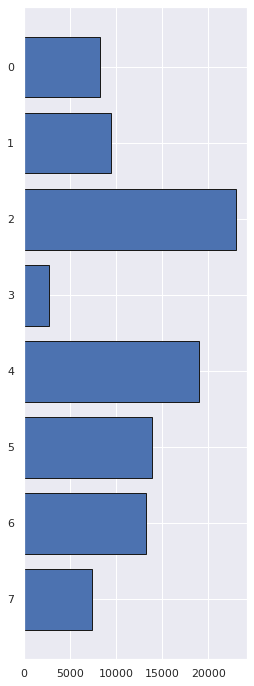

In [190]:
if True:
    nb_clusters = 8
    kmeans_model = KMeans(
        n_clusters=nb_clusters,
        random_state=1,
        n_init=8,
        max_iter=360,
        tol=0.00005
        ).fit(
            temp_df
            )
    # Ajout des groupes au dataframe
    temp_labels_df = temp_df.copy()
    temp_labels_df['k-means_label'] = kmeans_model.labels_
    # Séparation des groupes
    groupe_df_list = []
    group_df_len = {}
    for i in range(nb_clusters):
        groupe_df_list.append(
            temp_labels_df[temp_labels_df['k-means_label']==i]
        )
        group_df_len[i] = len(groupe_df_list[i])

    # Représentation des poids des différents groupes
    group_df_len = sorted(
        group_df_len.items(),
        key=lambda item:item[0],
        reverse=True
        )

    plt.figure(
        figsize=(4, 12)
        )
    plt.barh(
        [str(element[0]) for element in group_df_len],
        [element[1] for element in group_df_len],
        edgecolor='k'
        )

In [191]:
temp_df.head(5)

,distancia,delai_livraison_estime,retard_livraison,log(item_freight_value),log(item_price),log(payment_value),log(product_volume_cm3),log(product_weight_g),cat_eletronicos,h(24)_deliv,cat_cool_stuff,sta_GO,t_excelente,cat_telefonia,cat_bebes,pay_debit_card,review_score,sta_SP,cat_cama_mesa_banho,cat_esporte_lazer,sta_MG,y(2)_purch,sta_ES,number_of_products,t_recomendado,m_recomendo,cit_belo_horizonte,cit_brasilia,t_ótima,t_super,m_bem,pay_boleto,cd(365)_purch,sta_PR,cw(52)_purch,cat_ferramentas_jardim,t_ótimo,d(31)_purch,sta_RJ,sta_BA,t_bom,m_mas,cat_relogios_presentes,cat_papelaria,pay_credit_card,t_otimo,payment_installments,sta_SC,cit_sao_paulo,cit_rio_de_janeiro,pay_voucher,t_recomendo,cat_moveis_decoracao,pay_not_defined,sta_RS,cat_brinquedos,m_bom,product_photos_qty,cat_utilidades_domesticas,h(24)_purch,cat_informatica_acessorios,m(12)_purch,q(4)_purch,sta_DF,cat_perfumaria,wd(7)_deliv,cat_automotivo,cat_beleza_saude,wd(7)_purch
0,-0.978159,-0.952369,0.375801,-1.328811,-1.117183,-1.280859,-0.994454,-0.376597,0.0,0.913043,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005755,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.752747,0.0,0.764706,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.001326,0.0,0.041667,0.000000,0.008577,0.0,0.011196,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.434783,0.0,0.818182,1.000000,0.0,0.0,0.166667,0.0,0.000000,0.000000
1,-0.983123,-1.292190,0.177500,-1.549461,-1.117183,-1.311220,-0.994454,-0.376597,0.0,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005615,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.620879,0.0,0.627451,0.0,0.0,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.002764,0.0,0.125000,0.000000,0.008369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.782609,0.0,0.636364,0.666667,0.0,0.0,0.666667,0.0,0.000000,0.166667
2,-0.969885,-1.292190,0.375801,-1.549461,-1.117183,-1.311220,-0.994454,-0.376597,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.005615,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.585165,0.0,0.588235,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.002764,0.0,0.041667,0.000000,0.008369,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,0.782609,0.0,0.636364,0.666667,0.0,0.0,0.000000,0.0,0.000000,0.333333
3,-0.223582,-0.386001,0.574102,-0.399192,-1.117183,-1.120138,-0.994454,-0.376597,0.0,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006061,0.810440,0.0,0.823529,0.0,0.0,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.012025,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.006816,1.000000,0.0,0.818182,1.000000,0.0,0.0,0.166667,0.0,0.000000,0.000000
4,-0.969885,-1.292190,0.474952,-1.546977,-0.122300,-0.328619,-0.670360,-0.931054,0.0,0.826087,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.012442,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.607143,0.0,0.607843,0.0,0.0,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.006125,0.0,0.041667,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.000000,0.565217,0.0,0.636364,0.666667,0.0,0.0,0.333333,0.0,0.018512,0.500000


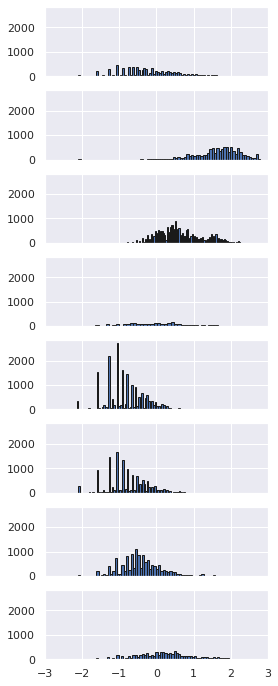

In [192]:
if True:
    temp_col = 'log(product_weight_g)'

    fig, axs = plt.subplots(
        nb_clusters,
        figsize=(4,12),
        sharex=True,
        sharey=True
        )
    plt.setp(
        axs,
        xlim=(-3, 3),
        #ylim=(0, 20000)
        )

    for i in range(nb_clusters):
        bins_nb = int(
            math.sqrt(
                len(
                    groupe_df_list[i][temp_col]
                    )
                )
            )
        axs[i].hist(
            groupe_df_list[i][temp_col],
            bins=bins_nb,
            label='Groupe {}'.format(i),
            edgecolor='k'
            )

## G Représentation dans le plan t-SNE

### 1 k-means

In [194]:
if False:
    # k-means
    kmeans_model = KMeans(
        n_clusters=nb_clusters,
        random_state=1,
        n_init=6,
        max_iter=360,
        tol=0.00005
        ).fit(
            temp_df
            )
    # t-SNE
    tsne_res = TSNE(
        n_components=2,
        random_state=0
        ).fit_transform(
            temp_df
            )

    # Augmenter d'une dimension
    kmeans_lab = np.expand_dims(
        kmeans_model.labels_,
        axis=1
        )
    # Ajouter les étiquettes k-means aux coordonnées t-SNE
    tsne_res_add = np.append(
        tsne_res,
        kmeans_lab,
        axis=1
        )

    # Visualisation
    sns.scatterplot(
        x = tsne_res_add[:,0],
        y = tsne_res_add[:,1],
        hue=tsne_res_add[:,2],
        palette=sns.hls_palette(nb_clusters),
        legend='full'
        )

### 2 DBSCAN

N.B.: Les paramètres sont figés dans la partie §E.2 (Optimisations)

In [195]:
if False:
    # Sélection du dataframe sur lequel effectuer la modélisation
    n_sample = len(temp_df)

    # DBSCAN
    db = DBSCAN(
        eps=eps_, 
        min_samples=min_samples_,
        leaf_size=leaf_size_
    ).fit(
        temp_df
    )
    core_samples_mask = np.zeros_like(
        db.labels_,
        dtype=bool
        )
    core_samples_mask[db.core_sample_indices_] = True

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

    labels = db.labels_

    unique, counts = np.unique(db.labels_, return_counts=True)
    my_dict = dict(zip(unique, counts))

    # t-SNE
    tsne_res = TSNE(
        n_components=2,
        random_state=0
        ).fit_transform(
            temp_df
            )

    # Augmenter d'une dimension
    dbscan_lab = np.expand_dims(
        db.labels_,
        axis=1
        )
    # Ajouter les étiquettes DBSCAN aux coordonnées t-SNE
    tsne_res_add = np.append(
        tsne_res,
        dbscan_lab,
        axis=1
        )

    # Visualisation
    sns.scatterplot(
        x = tsne_res_add[:,0],
        y = tsne_res_add[:,1],
        hue=tsne_res_add[:,2],
        palette=sns.hls_palette(n_clusters_+1),
        legend='full'
        )

In [196]:
if False:
    # Rejeter les points considérés comme du bruit
    tsne_res_add = np.array([element for element in tsne_res_add if element[2]!=-1])

    # Visualisation
    sns.scatterplot(
        x = tsne_res_add[:,0],
        y = tsne_res_add[:,1],
        hue=tsne_res_add[:,2],
        palette=sns.hls_palette(n_clusters_),
        legend='full'
        )

In [197]:
if False:
    plt.ylim(0, 20000)
    plt.bar(
        list(my_dict.keys()),
        list(my_dict.values()),
        edgecolor='k'
    )

In [198]:
if False:
    # Constitution d'une copie du dictionnaire pour récupérer le volume du cluster
    # le plus important
    my_dict_without_noise = my_dict.copy()
    del my_dict_without_noise[-1]

    # Enregistrement de la métrique Calinski-Harabasz
    ind_cal_har = metrics.calinski_harabasz_score(X=temp_df,labels=labels)

    # Compute the performance index for DBSCAN
    ind_dbscan = (
        abs(my_dict[-1] - 0.05*n_sample)/0.05 
        * abs(max(my_dict_without_noise.values())- 0.2*n_sample)**2
        ) / ind_cal_har
    int(ind_dbscan/1000000)